In [3]:
import pandas as pd

# Load the dataset
df = pd.read_csv("A2D_dataset.csv")

In [4]:
# Remove constant columns (columns with the same value across all rows)
df_filtered = df.loc[:, (df.nunique() > 1)]

In [5]:
import pandas as pd
import numpy as np  # Import numpy

# Identify highly correlated features
correlation_matrix = df_filtered.iloc[:, 1:-1].corr().abs()  # Excluding 'Name' and 'pIC50'
upper_triangle = correlation_matrix.where(
    ~np.tril(np.ones(correlation_matrix.shape), k=0).astype(bool) # Use np instead of pd.np
)

In [6]:
# Find columns with high correlation (> 0.9)
high_correlation_features = [
    column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)
]

In [7]:
# Drop highly correlated features
df_final = df_filtered.drop(columns=high_correlation_features)

In [8]:
# Save the cleaned dataset
df_final.to_csv("Filtered_Dataset.csv", index=False)

In [9]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr

In [10]:
# Load the cleaned dataset
df = pd.read_csv("Filtered_Dataset.csv")

In [11]:
# Splitting dataset (Retaining 'Name' column in train and test sets)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Save training and test sets
train_df.to_csv("Training_Dataset.csv", index=False)
test_df.to_csv("Test_Dataset.csv", index=False)

In [12]:
# Extract Features (X) and Target (y) without 'Name'
X_train = train_df.iloc[:, 1:-1]  # Molecular descriptors
y_train = train_df.iloc[:, -1]  # pIC50

X_test = test_df.iloc[:, 1:-1]
y_test = test_df.iloc[:, -1]

In [13]:
# Existing dictionary of untuned base models
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "SVM": SVR(kernel="rbf"),
    "XGBoost": XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42),
    "ANN": MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
}

# Assign to variables
best_rf = models["Random Forest"]
best_svm = models["SVM"]
best_xgb = models["XGBoost"]
best_ann = models["ANN"]


In [14]:
# K-Fold Cross-Validation Setup
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# List to store results
results_list = []

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Compute Metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_pearson = pearsonr(y_train, y_train_pred)[0]
    test_pearson = pearsonr(y_test, y_test_pred)[0]

    # Handle cross-validation for XGBoost separately
    if name == "XGBoost":
        model_cv = XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
    else:
        model_cv = model  # Use the same model for other regressors

    try:
        # Cross-validation scores
        cv_rmse = np.mean(np.sqrt(-cross_val_score(model_cv, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)))
        cv_r2 = np.mean(cross_val_score(model_cv, X_train, y_train, scoring='r2', cv=kf))
    except Exception as e:
        print(f"Cross-validation error for {name}: {e}")
        cv_rmse = np.nan
        cv_r2 = np.nan

    # Append results
    results_list.append({
        "Algorithm": name,
        "Train RMSE": train_rmse,
        "Test RMSE": test_rmse,
        "CV RMSE": cv_rmse,
        "Train MSE": train_mse,
        "Test MSE": test_mse,
        "Train MAE": train_mae,
        "Test MAE": test_mae,
        "Train R²": train_r2,
        "Test R²": test_r2,
        "CV R²": cv_r2,
        "Train Pearson": train_pearson,
        "Test Pearson": test_pearson
    })

In [15]:
# Convert results to DataFrame
results_df = pd.DataFrame(results_list)

In [16]:
# Save results to CSV
results_df.to_csv("Model_Performance.csv", index=False)

In [ ]:
# Load training and test datasets
train_file_path = "Training_Dataset.csv"
test_file_path = "Test_Dataset.csv"

train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

# Combine datasets for outlier analysis
train_df["Dataset"] = "Train"
test_df["Dataset"] = "Test"
combined_df = pd.concat([train_df, test_df])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist

# Extract molecular descriptors only (excluding Name, Dataset, and pIC50)
X = combined_df.drop(columns=['Name', 'Dataset', 'pIC50'])

# Apply PCA for dimensionality reduction (2D for visualization)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
combined_df["PCA1"] = X_pca[:, 0]
combined_df["PCA2"] = X_pca[:, 1]

# Apply K-means clustering on PCA-reduced data
kmeans = KMeans(n_clusters=2, random_state=42)
combined_df["Cluster"] = kmeans.fit_predict(X_pca)

# Determine Applicability Domain (AD) using cluster centroids
centroid_distances = cdist(X_pca, kmeans.cluster_centers_)  # Now using PCA space
combined_df["Distance_to_Centroid"] = np.min(centroid_distances, axis=1)

# Define threshold for outliers (e.g., top 5% farthest points)
outlier_threshold = np.percentile(combined_df["Distance_to_Centroid"], 95)
combined_df["Outlier"] = combined_df["Distance_to_Centroid"] > outlier_threshold

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
import matplotlib.patches as mpatches

# Standardize data before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(combined_df.drop(columns=['Name', 'Dataset', 'pIC50']))

# Apply PCA with higher components
pca = PCA(n_components=10)  # Keeping more variance initially
X_pca_full = pca.fit_transform(X_scaled)

# Retain only first 2 principal components for visualization
X_pca_2d = X_pca_full[:, :2]
combined_df["PCA1"] = X_pca_2d[:, 0]
combined_df["PCA2"] = X_pca_2d[:, 1]

# Apply K-means clustering on PCA-reduced data
kmeans = KMeans(n_clusters=2, random_state=42)
combined_df["Cluster"] = kmeans.fit_predict(X_pca_2d)

# Compute Mahalanobis distance instead of Euclidean
centroid_distances = cdist(X_pca_2d, kmeans.cluster_centers_, metric='mahalanobis')
combined_df["Distance_to_Centroid"] = np.min(centroid_distances, axis=1)

# Set stricter threshold for outliers (90th percentile)
outlier_threshold = np.percentile(combined_df["Distance_to_Centroid"], 90)
combined_df["Outlier"] = combined_df["Distance_to_Centroid"] > outlier_threshold

# Visualization
plt.figure(figsize=(8, 6))

# Scatter plot with only circular dots
sns.scatterplot(data=combined_df, x="PCA1", y="PCA2", hue="Outlier", style="Outlier",
                markers={False: "o", True: "o"}, palette={False: "blue", True: "red"})

# Create a custom legend with different colors
true_patch = mpatches.Patch(color='red', label="True")
false_patch = mpatches.Patch(color='blue', label="False")
plt.legend(handles=[false_patch, true_patch], title="Outlier")

# Remove axis labels for a cleaner look
plt.xlabel("PCA1")
plt.ylabel("PCA2")

# Save the figure with 600 dpi resolution
plt.savefig("PCA_Clean_Outliers_ColoredLegend.png", dpi=600, bbox_inches='tight')

plt.show()

In [ ]:
# Save outliers to CSV
outliers_df = combined_df[combined_df["Outlier"]]
outliers_df.to_csv("Outliers_Detected.csv", index=False)

# Remove outliers and save cleaned datasets
train_df_cleaned = train_df[~train_df["Name"].isin(outliers_df["Name"])]
test_df_cleaned = test_df[~test_df["Name"].isin(outliers_df["Name"])]

train_df_cleaned.to_csv("Training_Dataset_Cleaned.csv", index=False)
test_df_cleaned.to_csv("Test_Dataset_Cleaned.csv", index=False)

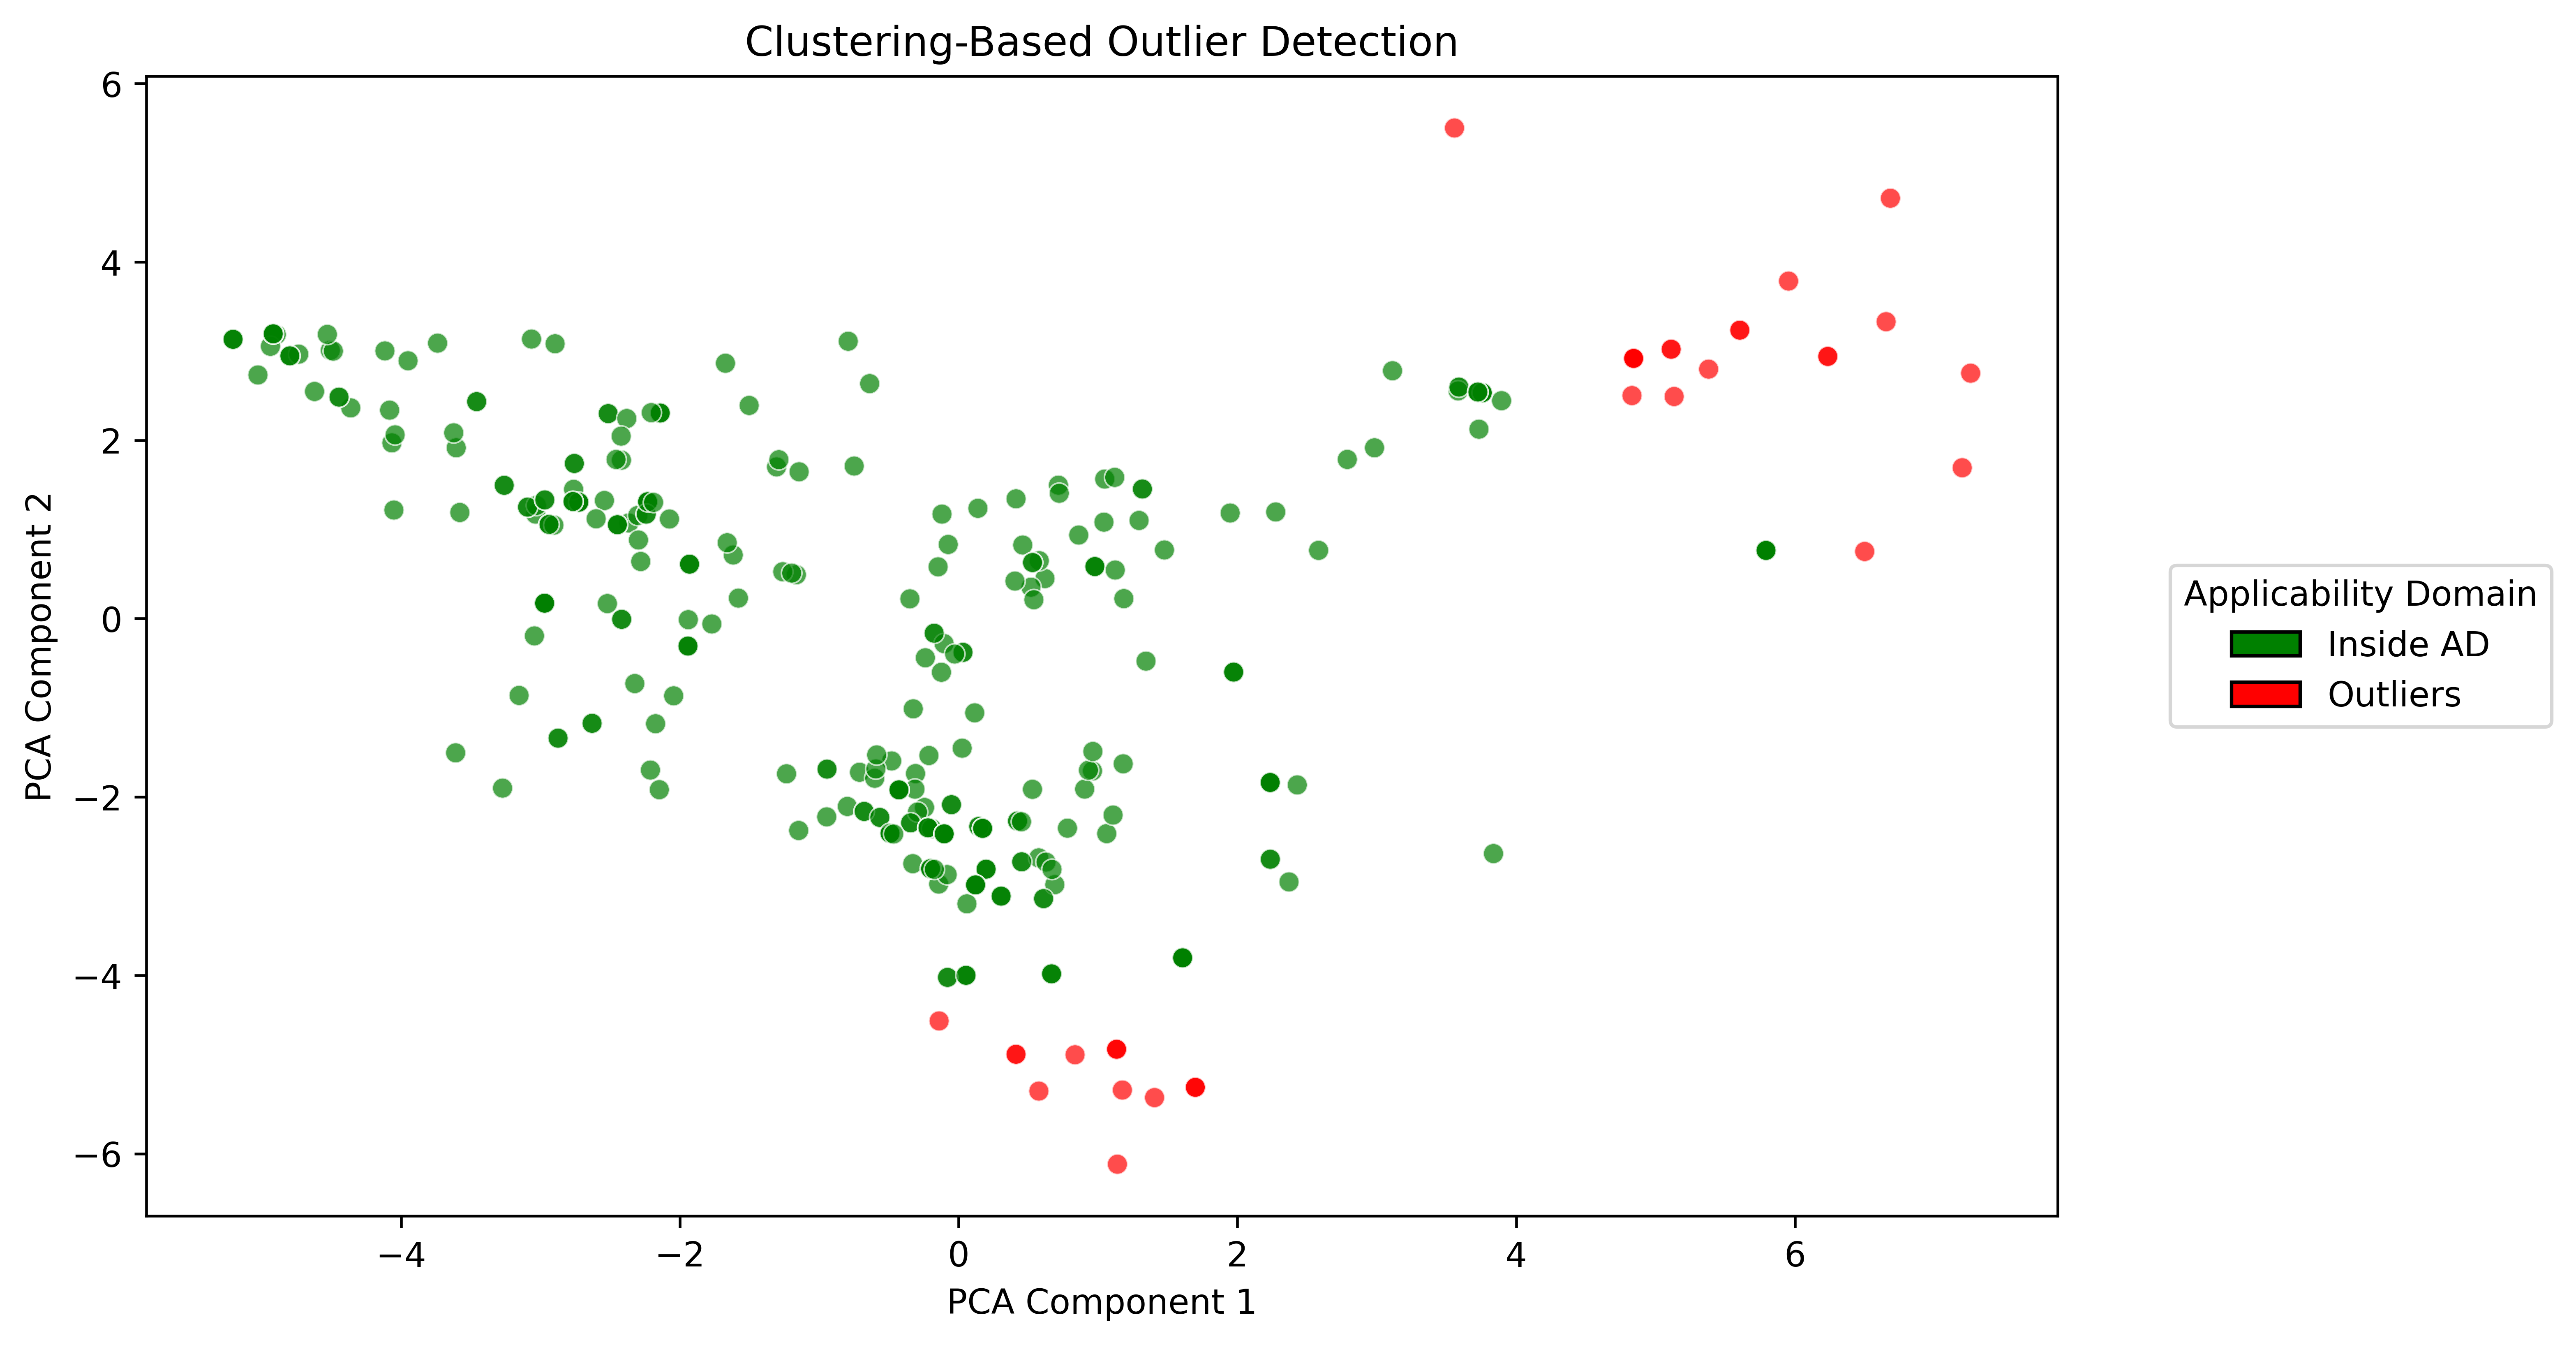

Plot saved successfully at: PCA_Clustering_Outliers.png


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

# Define colors explicitly
colors = {False: "green", True: "red"}

# Create scatter plot
fig, ax = plt.subplots(figsize=(10, 6), dpi=600)  # Explicitly create figure
sns.scatterplot(
    x=combined_df["PCA1"],
    y=combined_df["PCA2"],
    hue=combined_df["Outlier"],
    palette=colors,
    alpha=0.7
)

plt.title("Clustering-Based Outlier Detection")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

# Manually create legend outside the plot
legend_elements = [
    Patch(facecolor="green", edgecolor="black", label="Inside AD"),
    Patch(facecolor="red", edgecolor="black", label="Outliers")
]

plt.legend(
    handles=legend_elements,
    title="Applicability Domain",
    loc="center left",
    bbox_to_anchor=(1.05, 0.5)  # Moves legend outside the PCA box
)

# **Save the figure FIRST before showing it**
save_path = "PCA_Clustering_Outliers.png"  # Change to an absolute path if needed
fig.savefig(save_path, dpi=600, bbox_inches="tight")  # Use `fig.savefig()` instead of `plt.gcf().savefig()`

# **Now, display the plot**
plt.show()

print(f"Plot saved successfully at: {save_path}")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr

# Load cleaned training and test datasets
train_file_path = "Training_Dataset_Cleaned.csv"
test_file_path = "Test_Dataset_Cleaned.csv"

train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

In [ ]:
# Extract Features (X) and Target (y) without 'Name' and 'Dataset'
X_train = train_df.drop(columns=['Name', 'Dataset', 'pIC50'])  # Molecular descriptors
y_train = train_df['pIC50']  # pIC50

X_test = test_df.drop(columns=['Name', 'Dataset', 'pIC50'])
y_test = test_df['pIC50']

In [ ]:
# Initialize models with optimized hyperparameters
models = {
    "Random Forest": RandomForestRegressor(n_estimators=500, max_depth=25, min_samples_split=3, random_state=42),
    "SVM": SVR(kernel="rbf", C=15, gamma=0.005, epsilon=0.05),
    "ANN": MLPRegressor(hidden_layer_sizes=(256, 128, 64), activation='relu', solver='adam', max_iter=1500, random_state=42)
}

In [ ]:
# K-Fold Cross-Validation Setup
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# List to store results
results_list = []

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Compute Metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_pearson = pearsonr(y_train, y_train_pred)[0]
    test_pearson = pearsonr(y_test, y_test_pred)[0]

    # Cross-validation scores
    try:
        cv_rmse = np.mean(np.sqrt(-cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)))
        cv_r2 = np.mean(cross_val_score(model, X_train, y_train, scoring='r2', cv=kf))
    except Exception as e:
        print(f"Cross-validation error for {name}: {e}")
        cv_rmse = np.nan
        cv_r2 = np.nan

    # Append results
    results_list.append({
        "Algorithm": name,
        "Train RMSE": train_rmse,
        "Test RMSE": test_rmse,
        "CV RMSE": cv_rmse,
        "Train MSE": train_mse,
        "Test MSE": test_mse,
        "Train MAE": train_mae,
        "Test MAE": test_mae,
        "Train R²": train_r2,
        "Test R²": test_r2,
        "CV R²": cv_r2,
        "Train Pearson": train_pearson,
        "Test Pearson": test_pearson
    })

In [ ]:
# Convert results to DataFrame
results_df = pd.DataFrame(results_list)

# Save results to CSV
results_df.to_csv("Model_Performance_Cleaned.csv", index=False)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr

# Load cleaned training and test datasets
train_file_path = "Training_Dataset_Cleaned.csv"
test_file_path = "Test_Dataset_Cleaned.csv"

train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

# Extract Features (X) and Target (y) without 'Name' and 'Dataset'
X_train = train_df.drop(columns=['Name', 'Dataset', 'pIC50'])  # Molecular descriptors
y_train = train_df['pIC50']  # pIC50

X_test = test_df.drop(columns=['Name', 'Dataset', 'pIC50'])
y_test = test_df['pIC50']

# Define K-Fold for Cross-Validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

In [ ]:
# 1️⃣ **Random Forest Hyperparameter Tuning**
rf_params = {
    "n_estimators": [100, 300, 500, 700],
    "max_depth": [10, 20, 30, None],
    "min_samples_split": [2, 4, 6],
    "max_features": ["sqrt", "log2"]
}

rf_grid = RandomizedSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=kf, n_iter=10, scoring="r2", n_jobs=-1)
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_

# 2️⃣ **SVM Hyperparameter Tuning**
svm_params = {
    "C": [1, 10, 50, 100],
    "gamma": [0.1, 0.01, 0.001, 0.0001],
    "epsilon": [0.01, 0.05, 0.1, 0.2],
    "kernel": ["rbf", "poly", "sigmoid"]
}

svm_grid = RandomizedSearchCV(SVR(), svm_params, cv=kf, n_iter=10, scoring="r2", n_jobs=-1)
svm_grid.fit(X_train, y_train)
best_svm = svm_grid.best_estimator_

# 3️⃣ **ANN Hyperparameter Tuning**
ann_params = {
    "hidden_layer_sizes": [(128, 64), (256, 128, 64), (512, 256, 128)],
    "activation": ["relu", "tanh"],
    "solver": ["adam", "sgd"],
    "learning_rate_init": [0.001, 0.01, 0.1],
    "max_iter": [1000, 1500, 2000]
}

ann_grid = RandomizedSearchCV(MLPRegressor(random_state=42), ann_params, cv=kf, n_iter=10, scoring="r2", n_jobs=-1)
ann_grid.fit(X_train, y_train)
best_ann = ann_grid.best_estimator_

# Final Best Models
models = {
    "Random Forest": best_rf,
    "SVM": best_svm,
    "ANN": best_ann
}

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
9 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py", line 754, in fit
    return se

In [ ]:
# List to store results
results_list = []

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Compute Metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_pearson = pearsonr(y_train, y_train_pred)[0]
    test_pearson = pearsonr(y_test, y_test_pred)[0]

    # Cross-validation scores
    try:
        cv_rmse = np.mean(np.sqrt(-cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)))
        cv_r2 = np.mean(cross_val_score(model, X_train, y_train, scoring='r2', cv=kf))
    except Exception as e:
        print(f"Cross-validation error for {name}: {e}")
        cv_rmse = np.nan
        cv_r2 = np.nan

    # Append results
    results_list.append({
        "Algorithm": name,
        "Train RMSE": train_rmse,
        "Test RMSE": test_rmse,
        "CV RMSE": cv_rmse,
        "Train MSE": train_mse,
        "Test MSE": test_mse,
        "Train MAE": train_mae,
        "Test MAE": test_mae,
        "Train R²": train_r2,
        "Test R²": test_r2,
        "CV R²": cv_r2,
        "Train Pearson": train_pearson,
        "Test Pearson": test_pearson
    })

In [ ]:
# Convert results to DataFrame
results_df = pd.DataFrame(results_list)

# Save results to CSV
results_df.to_csv("Model_Performance_HyperTuned.csv", index=False)

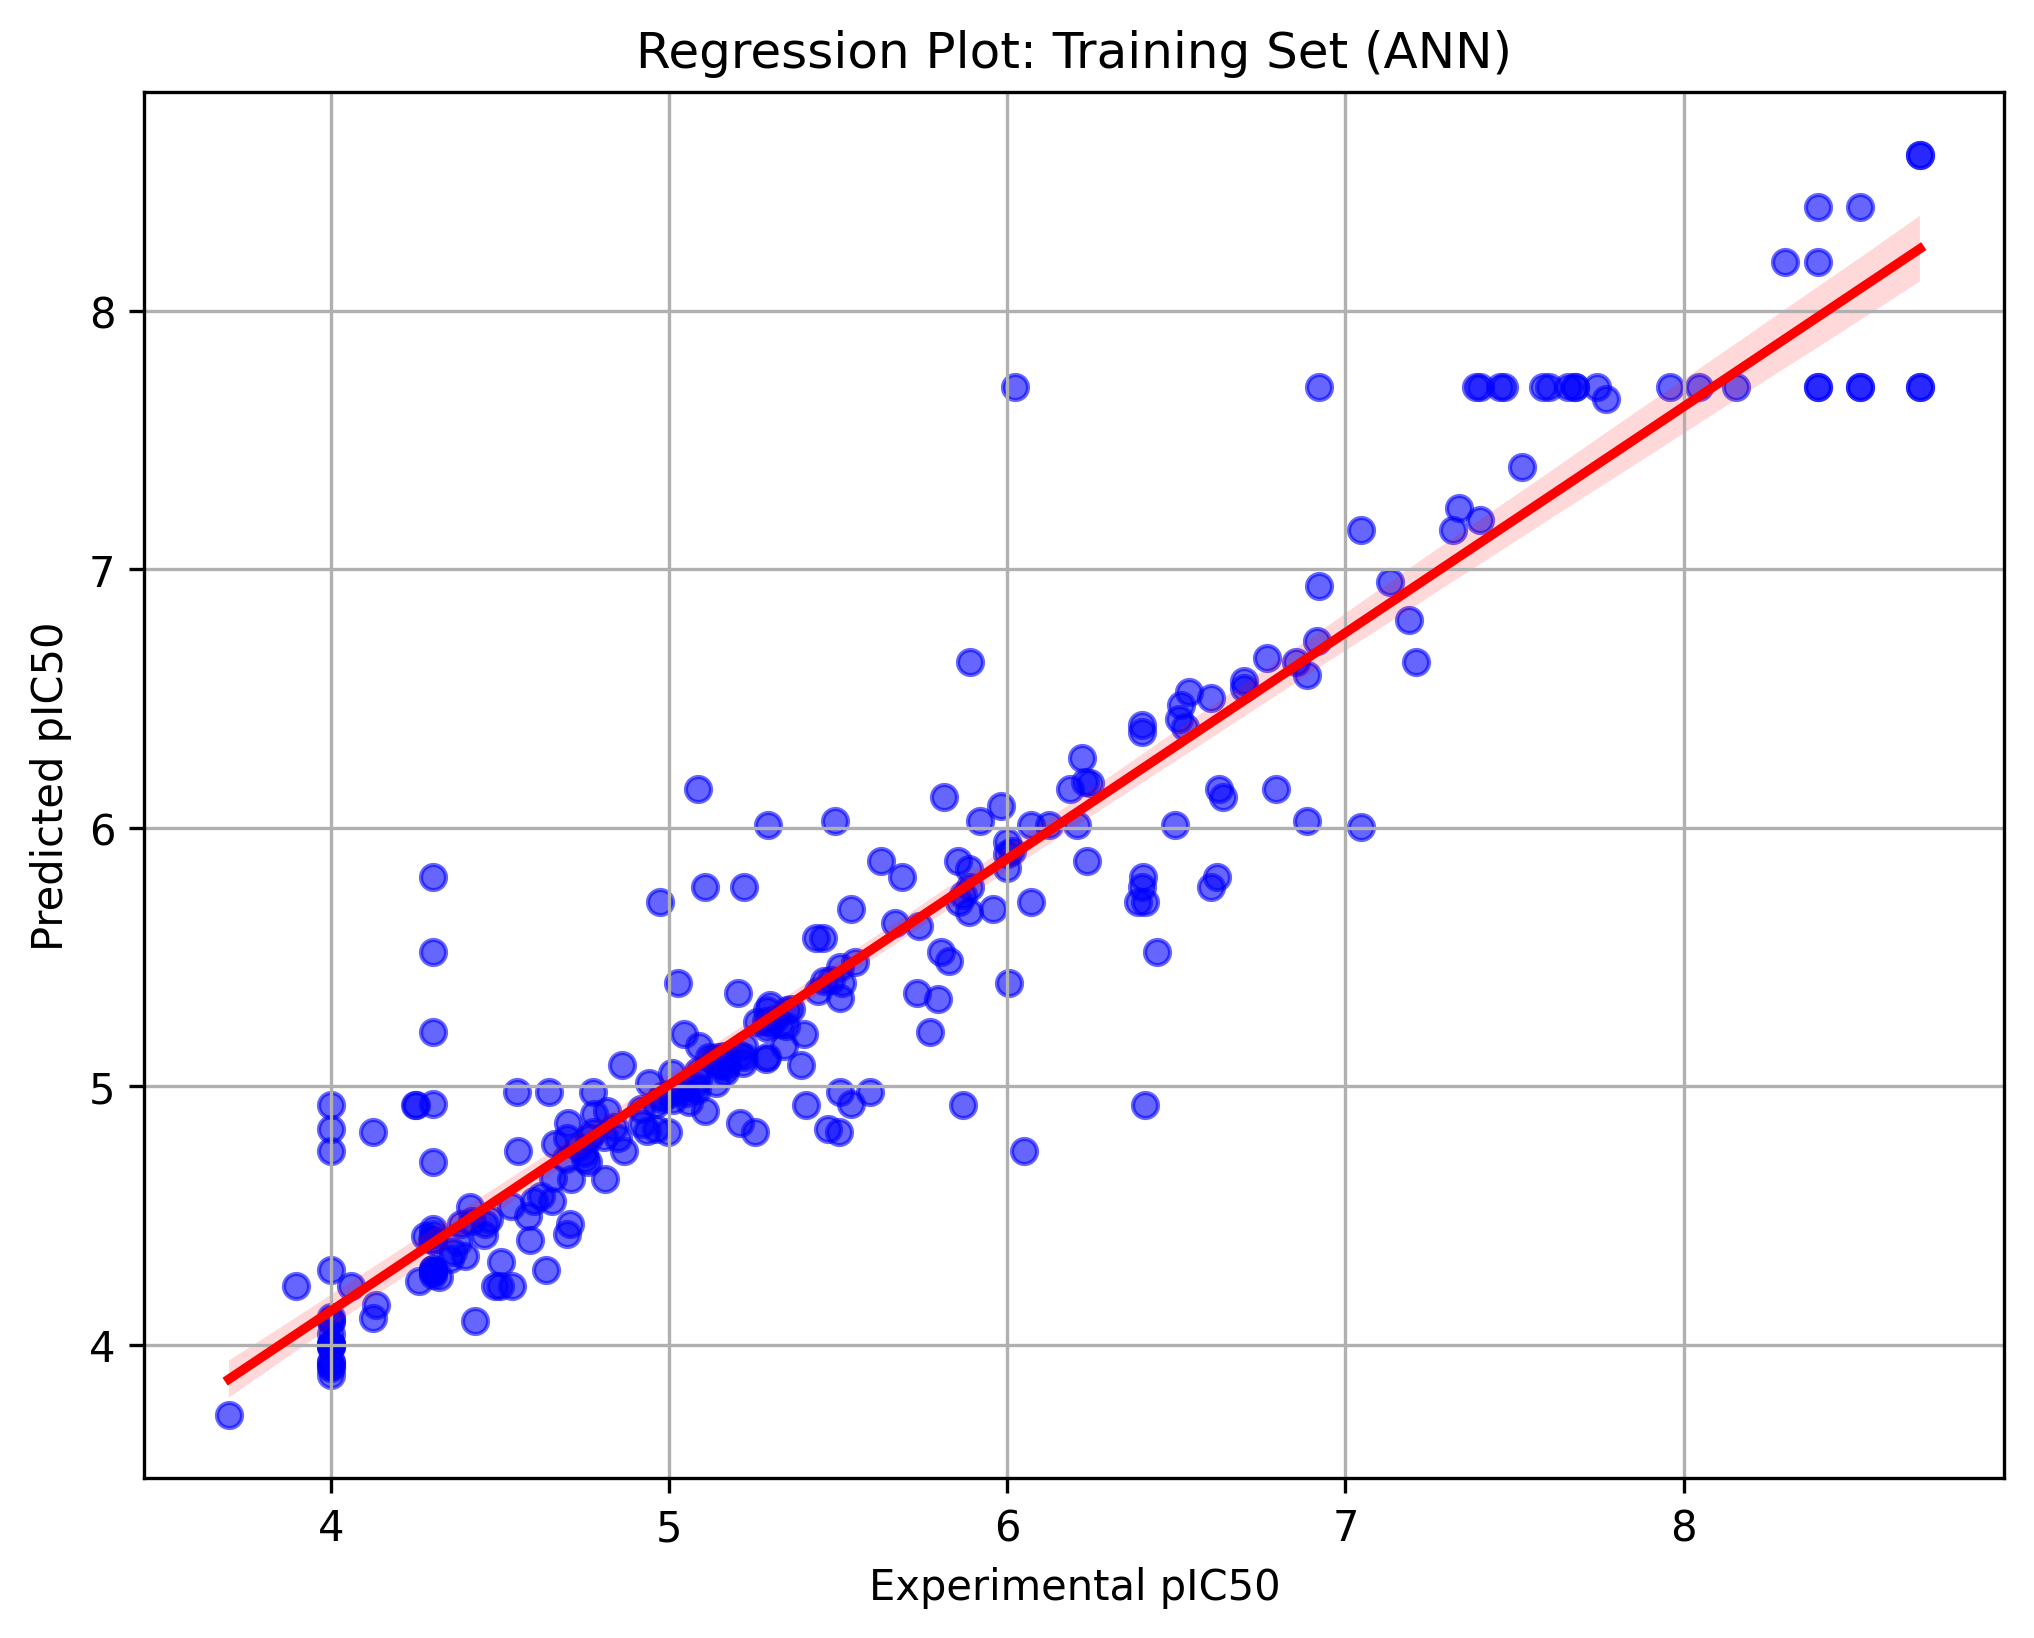

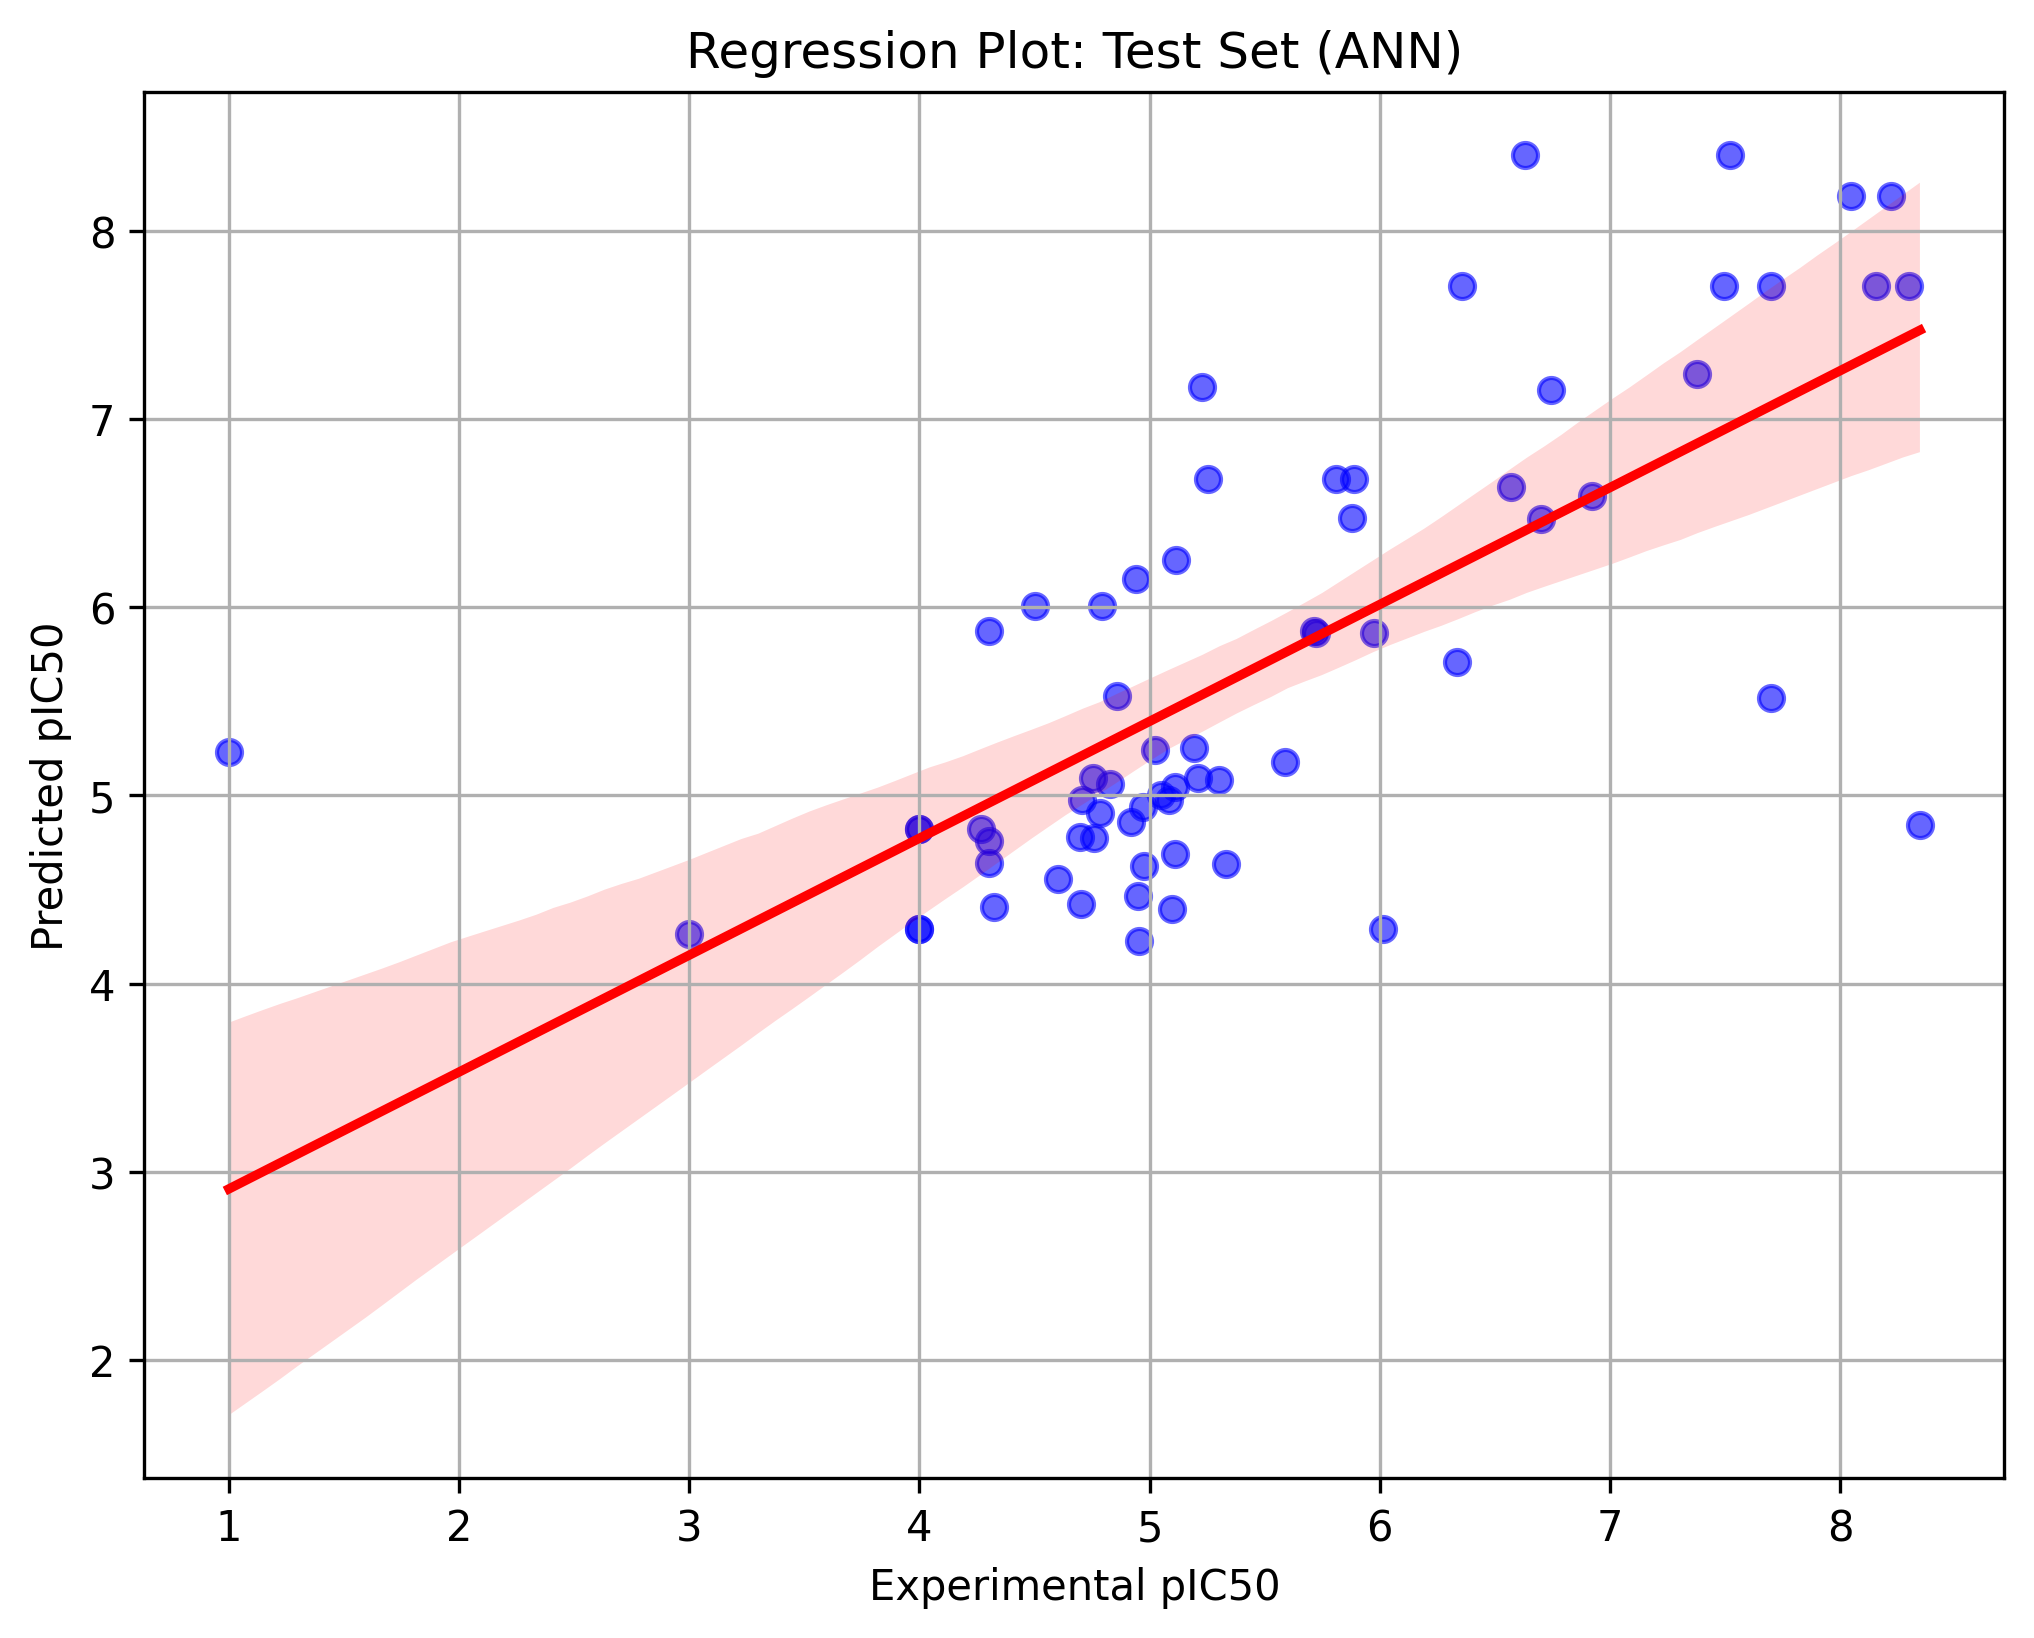

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get predictions from the best ANN model
y_train_pred_ann = best_ann.predict(X_train)
y_test_pred_ann = best_ann.predict(X_test)

# Save training set predictions
train_predictions_df = pd.DataFrame({
    "Name": train_df.iloc[:, 0],  # Assuming first column is Name
    "Experimental_pIC50": y_train,
    "Predicted_pIC50": y_train_pred_ann
})
train_predictions_file = "Training_Predictions_ANN.csv"
train_predictions_df.to_csv(train_predictions_file, index=False)

# Save test set predictions
test_predictions_df = pd.DataFrame({
    "Name": test_df.iloc[:, 0],  # Assuming first column is Name
    "Experimental_pIC50": y_test,
    "Predicted_pIC50": y_test_pred_ann
})
test_predictions_file = "Test_Predictions_ANN.csv"
test_predictions_df.to_csv(test_predictions_file, index=False)

# Plot regression plots for Training Set
plt.figure(figsize=(8, 6), dpi=300)
sns.regplot(x=y_train, y=y_train_pred_ann, scatter_kws={"color": "blue", "alpha": 0.6}, line_kws={"color": "red"})
plt.xlabel("Experimental pIC50")
plt.ylabel("Predicted pIC50")
plt.title("Regression Plot: Training Set (ANN)")
plt.grid()

# Save Training Regression Plot
train_regression_plot_path = "Regression_Plot_Training_ANN.png"
plt.savefig(train_regression_plot_path, dpi=600)
plt.show()

# Plot regression plots for Test Set
plt.figure(figsize=(8, 6), dpi=300)
sns.regplot(x=y_test, y=y_test_pred_ann, scatter_kws={"color": "blue", "alpha": 0.6}, line_kws={"color": "red"})
plt.xlabel("Experimental pIC50")
plt.ylabel("Predicted pIC50")
plt.title("Regression Plot: Test Set (ANN)")
plt.grid()

# Save Test Regression Plot
test_regression_plot_path = "Regression_Plot_Test_ANN.png"
plt.savefig(test_regression_plot_path, dpi=600)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance

# Ensure X_train is loaded
train_file_path = "Training_Dataset_Cleaned.csv"
train_df = pd.read_csv(train_file_path)

In [ ]:
# Extract Features and Target
X_train = train_df.drop(columns=['Name', 'Dataset', 'pIC50'])  # Molecular descriptors
y_train = train_df['pIC50']  # pIC50

In [ ]:
# Assuming the trained ANN model is named 'best_ann'
# Compute Permutation Importance (ANN doesn't have built-in feature importance)
perm_importance = permutation_importance(best_ann, X_train, y_train, scoring="r2", n_repeats=10, random_state=42)

<ipython-input-47-d29cdd54a1a4>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_features["Feature"], x=top_features["Importance"], palette="viridis")


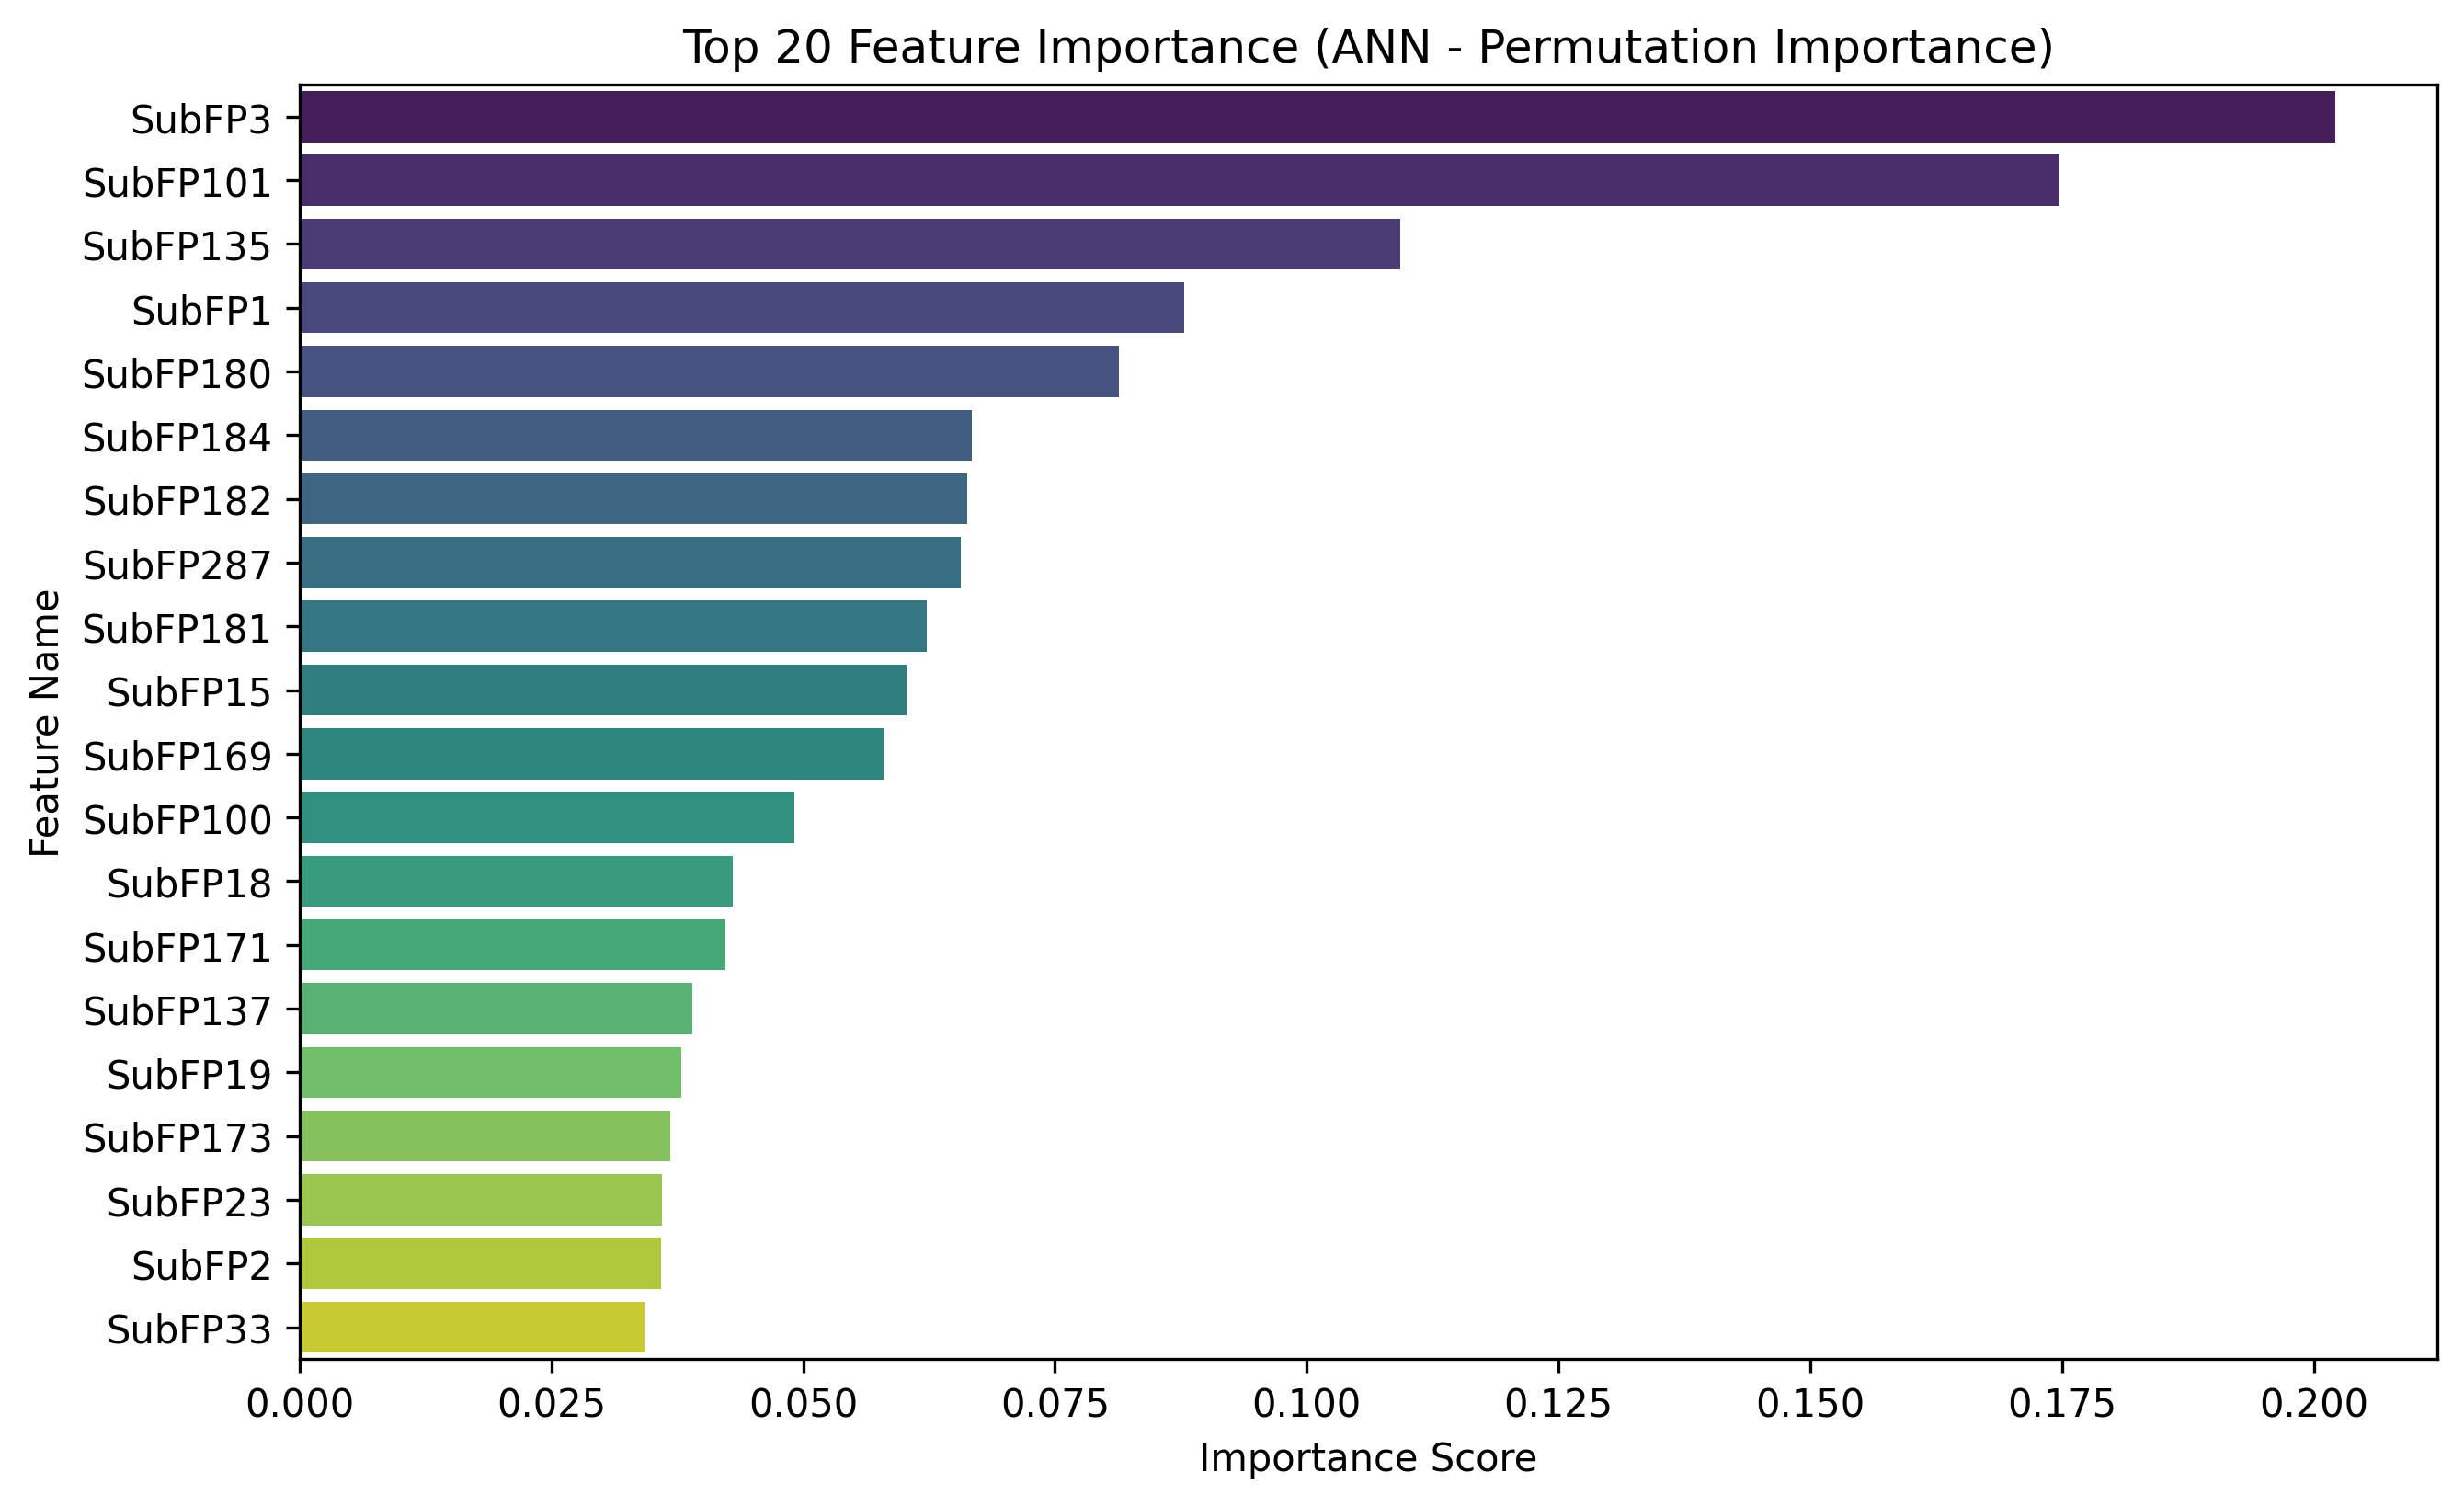

In [ ]:
# Create DataFrame for feature importance
feature_names = X_train.columns
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": perm_importance.importances_mean})

# Sort features by importance (Top 20)
top_features = importance_df.sort_values(by="Importance", ascending=False).head(20)

# Plot Feature Importance
plt.figure(figsize=(10, 6), dpi=300)
sns.barplot(y=top_features["Feature"], x=top_features["Importance"], palette="viridis")
plt.title("Top 20 Feature Importance (ANN - Permutation Importance)")
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")

# Save feature importance plot
feature_importance_plot_path = "Feature_Importance_ANN_Top20.png"
plt.savefig(feature_importance_plot_path, dpi=600, bbox_inches="tight")
plt.show()

Text(0.5, 1.0, 'Correlation Matrix of Top 20 Features (ANN)')

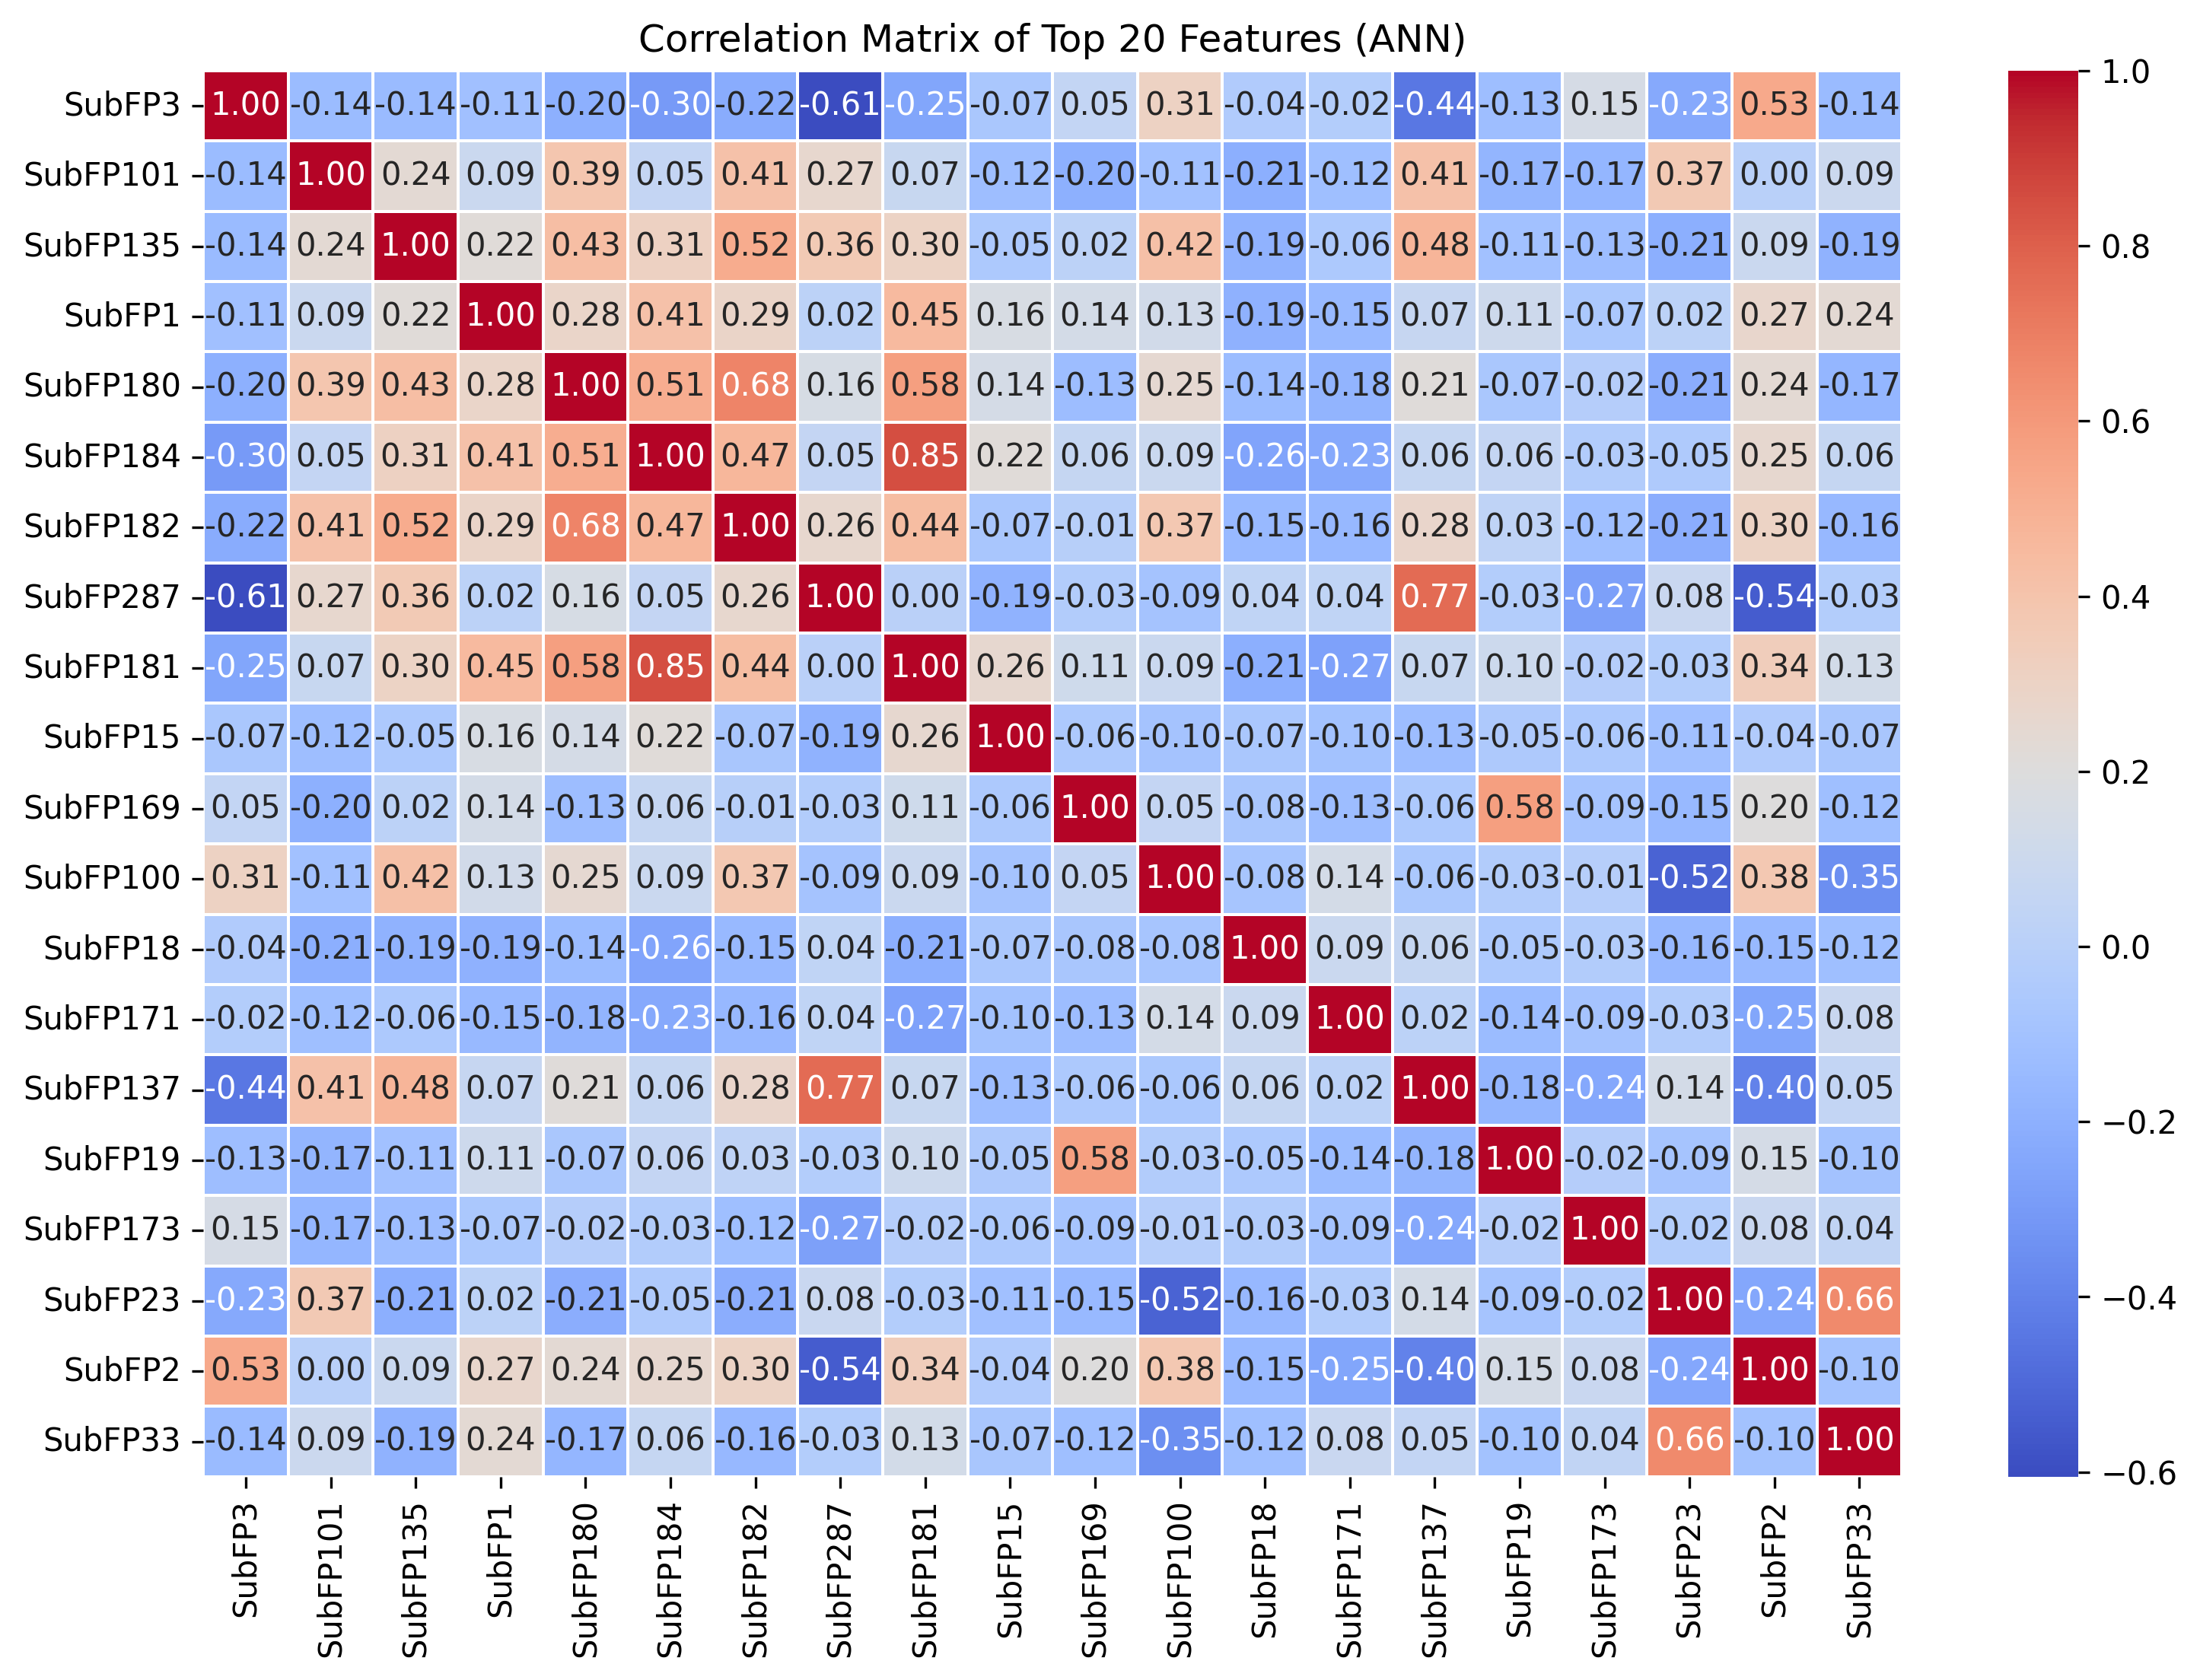

In [ ]:
# Extract the top 20 feature names for correlation matrix
top_feature_names = top_features["Feature"].values

# Compute Correlation Matrix for Top 20 Features
correlation_matrix = X_train[top_feature_names].corr()

# Plot Correlation Matrix Heatmap
plt.figure(figsize=(12, 8), dpi=300)
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Top 20 Features (ANN)")

<ipython-input-49-72e9ebb76bcc>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=pearson_df["Feature"], x=pearson_df["Pearson Correlation"], palette="coolwarm")


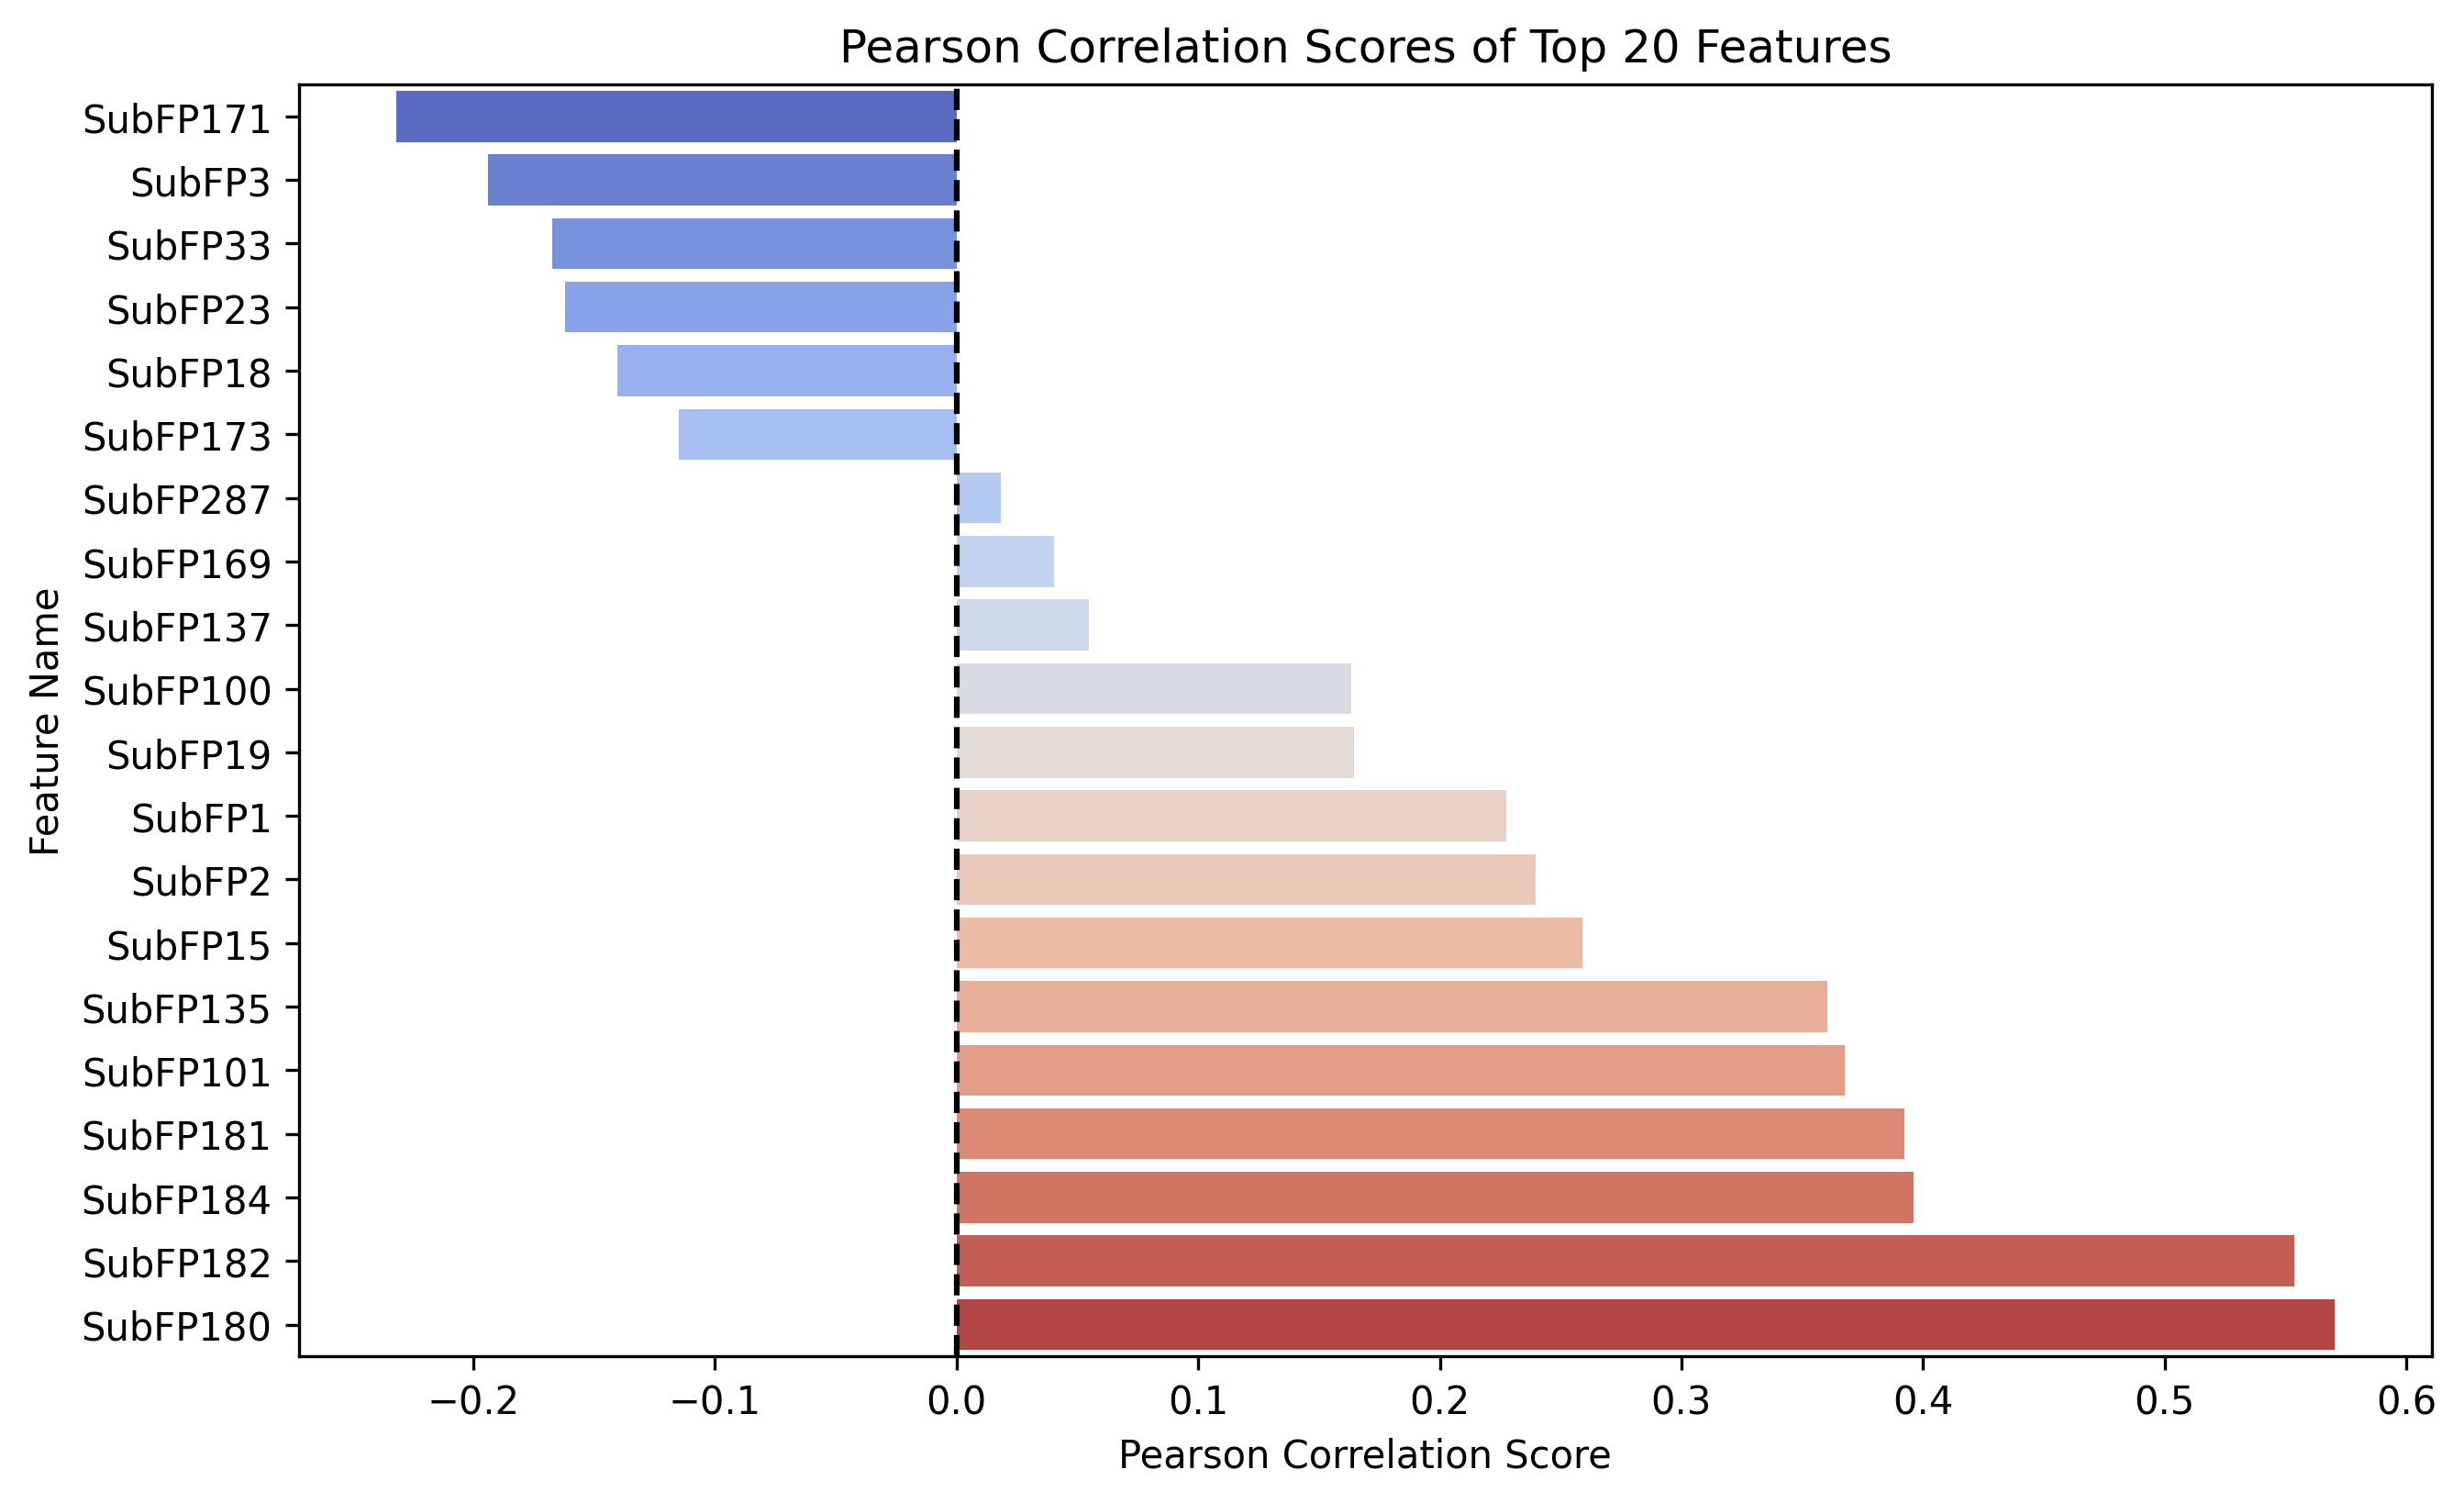

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute Pearson correlation scores of the top 20 features with pIC50
pearson_correlation_scores = X_train[top_feature_names].corrwith(y_train)

# Convert to DataFrame for better visualization
pearson_df = pd.DataFrame({"Feature": top_feature_names, "Pearson Correlation": pearson_correlation_scores.values})

# Sort features by correlation score
pearson_df = pearson_df.sort_values(by="Pearson Correlation")

# Plot Pearson Correlation scores
plt.figure(figsize=(10, 6), dpi=300)
sns.barplot(y=pearson_df["Feature"], x=pearson_df["Pearson Correlation"], palette="coolwarm")
plt.axvline(x=0, color="black", linestyle="--")
plt.title("Pearson Correlation Scores of Top 20 Features")
plt.xlabel("Pearson Correlation Score")
plt.ylabel("Feature Name")

# Save the Pearson correlation plot at 600 DPI
pearson_correlation_plot_path = "Pearson_Correlation_Top20.png"
plt.savefig(pearson_correlation_plot_path, dpi=600)
plt.show()

In [ ]:
# Save correlation matrix plot
correlation_matrix_plot_path = "Correlation_Matrix_ANN_Top20.png"
plt.savefig(correlation_matrix_plot_path, dpi=600, bbox_inches="tight")
plt.show()

<Figure size 640x480 with 0 Axes>

PermutationExplainer explainer: 271it [00:43,  6.21it/s]


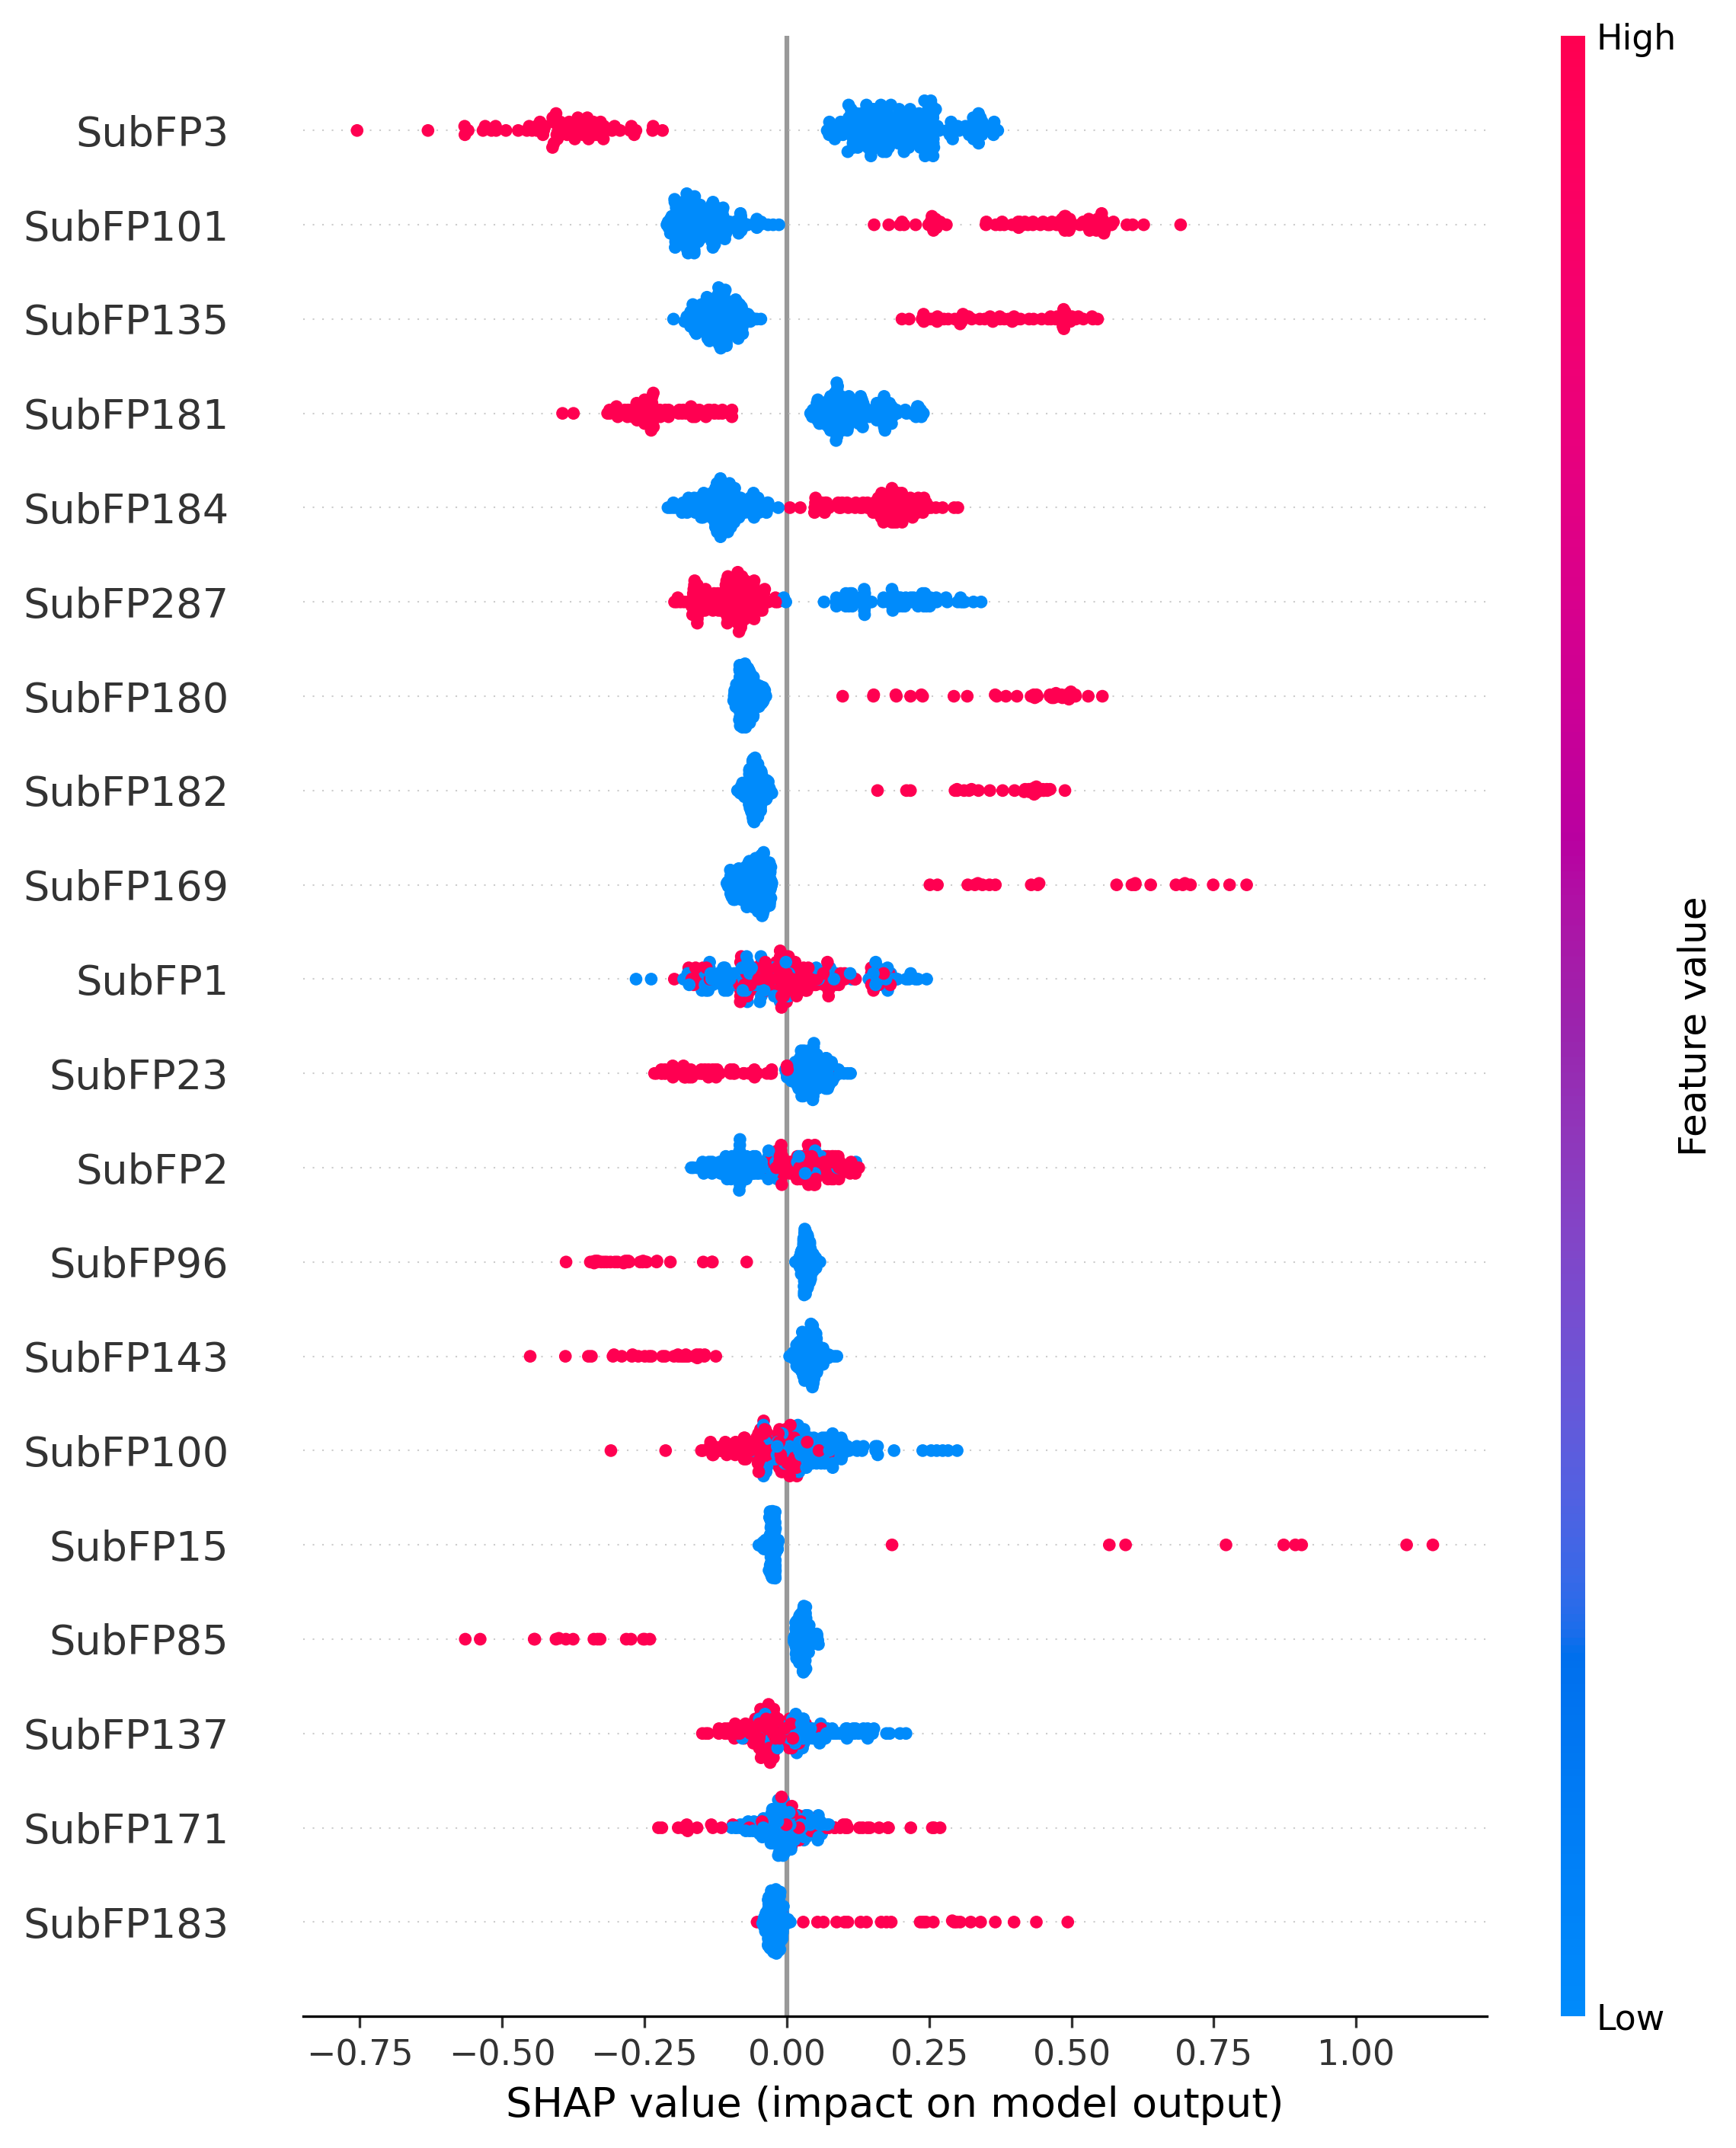

'SHAP_Analysis_ANN.png'

In [ ]:
#SHAP Analysis

!pip install shap
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# Load cleaned dataset
train_file_path = "Training_Dataset_Cleaned.csv"
train_df = pd.read_csv(train_file_path)

# Extract Features (X) and Target (y)
X_train = train_df.drop(columns=['Name', 'Dataset', 'pIC50'])  # Molecular descriptors
y_train = train_df['pIC50']  # pIC50

# Create SHAP Explainer for ANN, using model.predict as the callable function
# This is the key change to address the TypeError
explainer = shap.Explainer(best_ann.predict, X_train)
shap_values = explainer(X_train)

# Plot SHAP Summary
plt.figure(figsize=(10, 6), dpi=300)
shap.summary_plot(shap_values, X_train, show=False)

# Save SHAP plot at 600 DPI without tight layout
shap_plot_path = "SHAP_Analysis_ANN.png"
plt.savefig(shap_plot_path, dpi=600)
plt.show()

# Return file path for download
shap_plot_path

In [ ]:
import pandas as pd

# Load cleaned training and test datasets
train_file_path = "Training_Dataset_Cleaned.csv"
test_file_path = "Test_Dataset_Cleaned.csv"

train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

# Combine both datasets
combined_df = pd.concat([train_df, test_df], ignore_index=True)

# Separate molecules with pIC50 ≥ 7 (High Activity) and pIC50 ≤ 4 (Low Activity)
high_activity = combined_df[combined_df["pIC50"] >= 8]
low_activity = combined_df[combined_df["pIC50"] <= 4]

# Save separate CSV files
high_activity.to_csv("High_Activity_Molecules.csv", index=False)
low_activity.to_csv("Low_Activity_Molecules.csv", index=False)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform

# Load the high-activity dataset
high_activity_file = "High_Activity_Molecules.csv"
high_activity_df = pd.read_csv(high_activity_file)

# Extract molecule names
molecule_names = high_activity_df["Name"]

# Drop unnecessary columns (pIC50, Dataset, Name)
fingerprint_data = high_activity_df.drop(columns=["pIC50", "Dataset", "Name"])

# Compute Tanimoto similarity matrix using Jaccard distance
tanimoto_matrix = 1 - squareform(pdist(fingerprint_data, metric="jaccard"))

# Convert to DataFrame for visualization
tanimoto_df = pd.DataFrame(tanimoto_matrix, index=molecule_names, columns=molecule_names)

# Plot the heatmap
plt.figure(figsize=(15, 15), dpi=600)
sns.heatmap(tanimoto_df, cmap="coolwarm", xticklabels=True, yticklabels=True)
plt.title("Tanimoto Similarity Matrix of Highly Active Molecules")
plt.xlabel("Molecule Name")
plt.ylabel("Molecule Name")

# Save the heatmap at 600 DPI
tanimoto_plot_path = "Tanimoto_Similarity_High_Activity.png"
plt.savefig(tanimoto_plot_path, dpi=600)
plt.show()

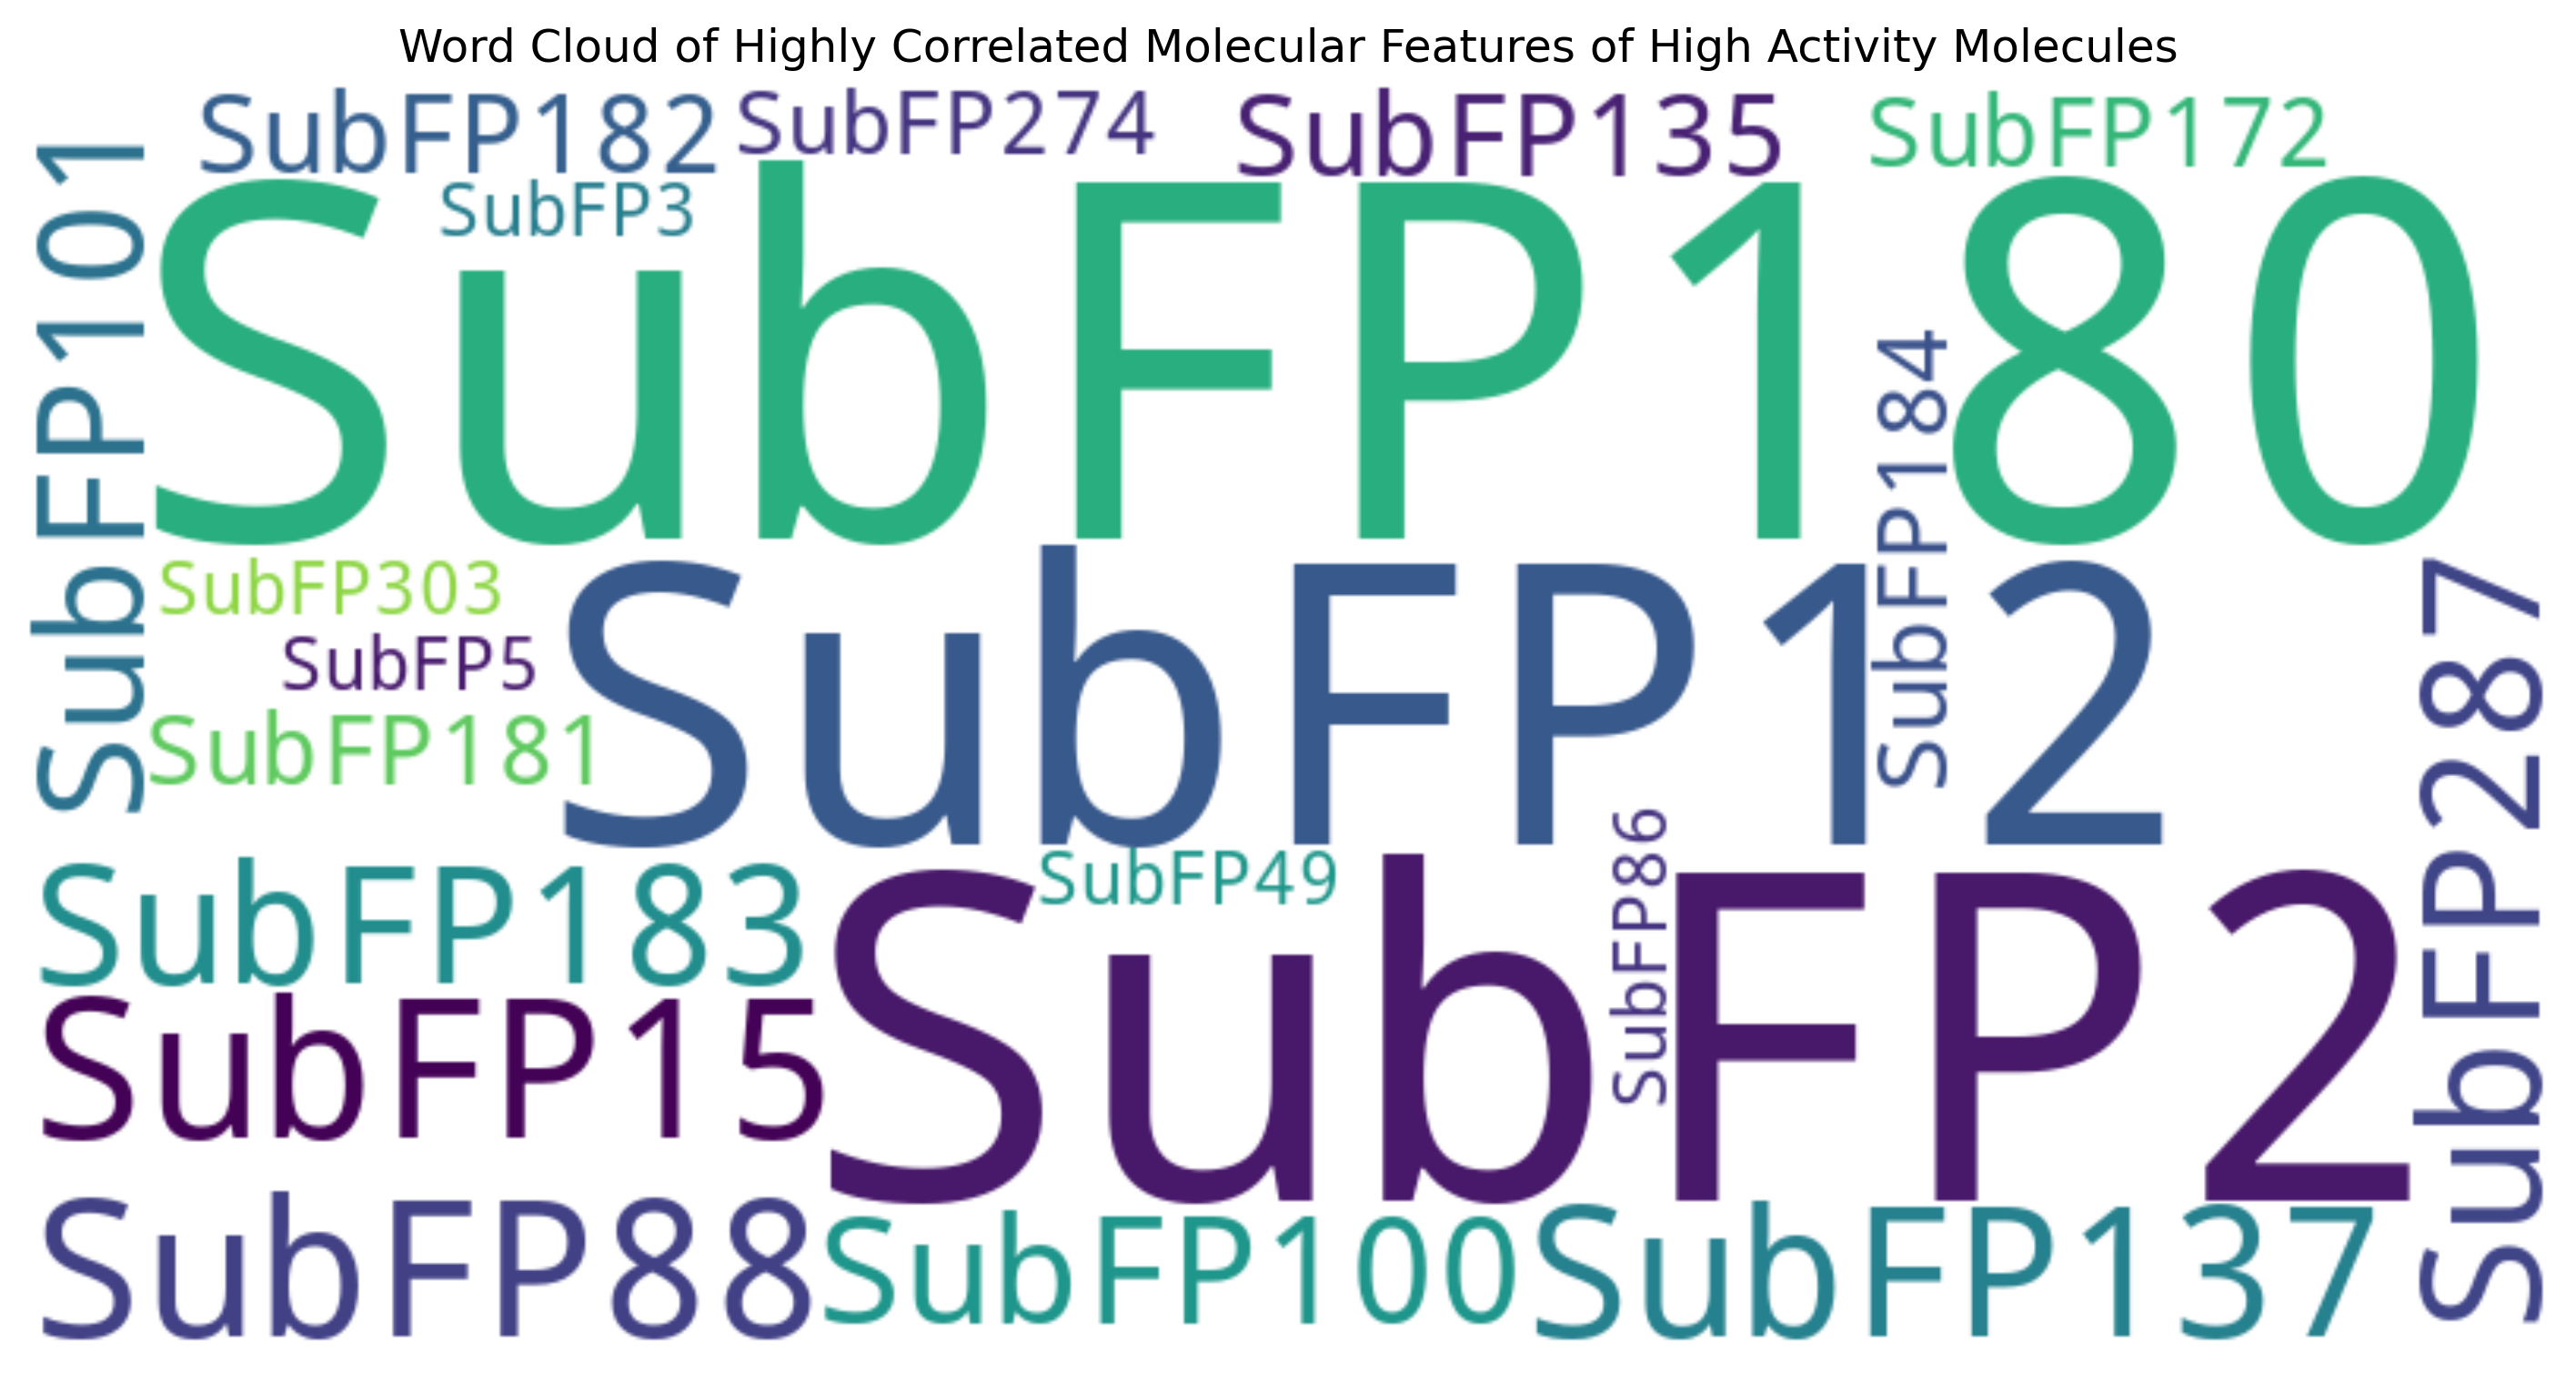

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Load the high-activity dataset
high_activity_file = "High_Activity_Molecules.csv"
high_activity_df = pd.read_csv(high_activity_file)

# Drop unnecessary columns (pIC50, Dataset, Name)
feature_data = high_activity_df.drop(columns=["pIC50", "Dataset", "Name"])

# Compute Correlation Matrix
correlation_matrix = feature_data.corr()

# Extract highly correlated features (|correlation| > 0.75)
high_correlation = (correlation_matrix.abs() > 0.50) & (correlation_matrix != 1.0)
important_features = high_correlation.sum(axis=1)
important_features = important_features[important_features > 0]  # Keep only relevant features

# Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(important_features)

# Plot the Word Cloud
plt.figure(figsize=(12, 6), dpi=300)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Highly Correlated Molecular Features of High Activity Molecules")

# Save the word cloud plot
wordcloud_plot_path = "WordCloud_Highly_Correlated_Features_High_Activity_Molecules.png"
plt.savefig(wordcloud_plot_path, dpi=600)
plt.show()

# Display important features in a DataFrame
important_features_df = important_features.reset_index()
important_features_df.columns = ["Feature", "Correlation Count"]


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform

# Load the low-activity dataset
low_activity_file = "Low_Activity_Molecules.csv"
low_activity_df = pd.read_csv(low_activity_file)

# Extract molecule names
molecule_names = low_activity_df["Name"]

# Drop unnecessary columns (pIC50, Dataset, Name)
fingerprint_data = low_activity_df.drop(columns=["pIC50", "Dataset", "Name"])

# Compute Tanimoto similarity matrix using Jaccard distance
tanimoto_matrix = 1 - squareform(pdist(fingerprint_data, metric="jaccard"))

# Convert to DataFrame for visualization
tanimoto_df = pd.DataFrame(tanimoto_matrix, index=molecule_names, columns=molecule_names)

# Plot the heatmap
plt.figure(figsize=(15, 15), dpi=600)
sns.heatmap(tanimoto_df, cmap="coolwarm", xticklabels=True, yticklabels=True)
plt.title("Tanimoto Similarity Matrix of Low Activity Molecules")
plt.xlabel("Molecule Name")
plt.ylabel("Molecule Name")

# Save the heatmap at 600 DPI
tanimoto_plot_path = "Tanimoto_Similarity_Low_Activity.png"
plt.savefig(tanimoto_plot_path, dpi=600)
plt.show()

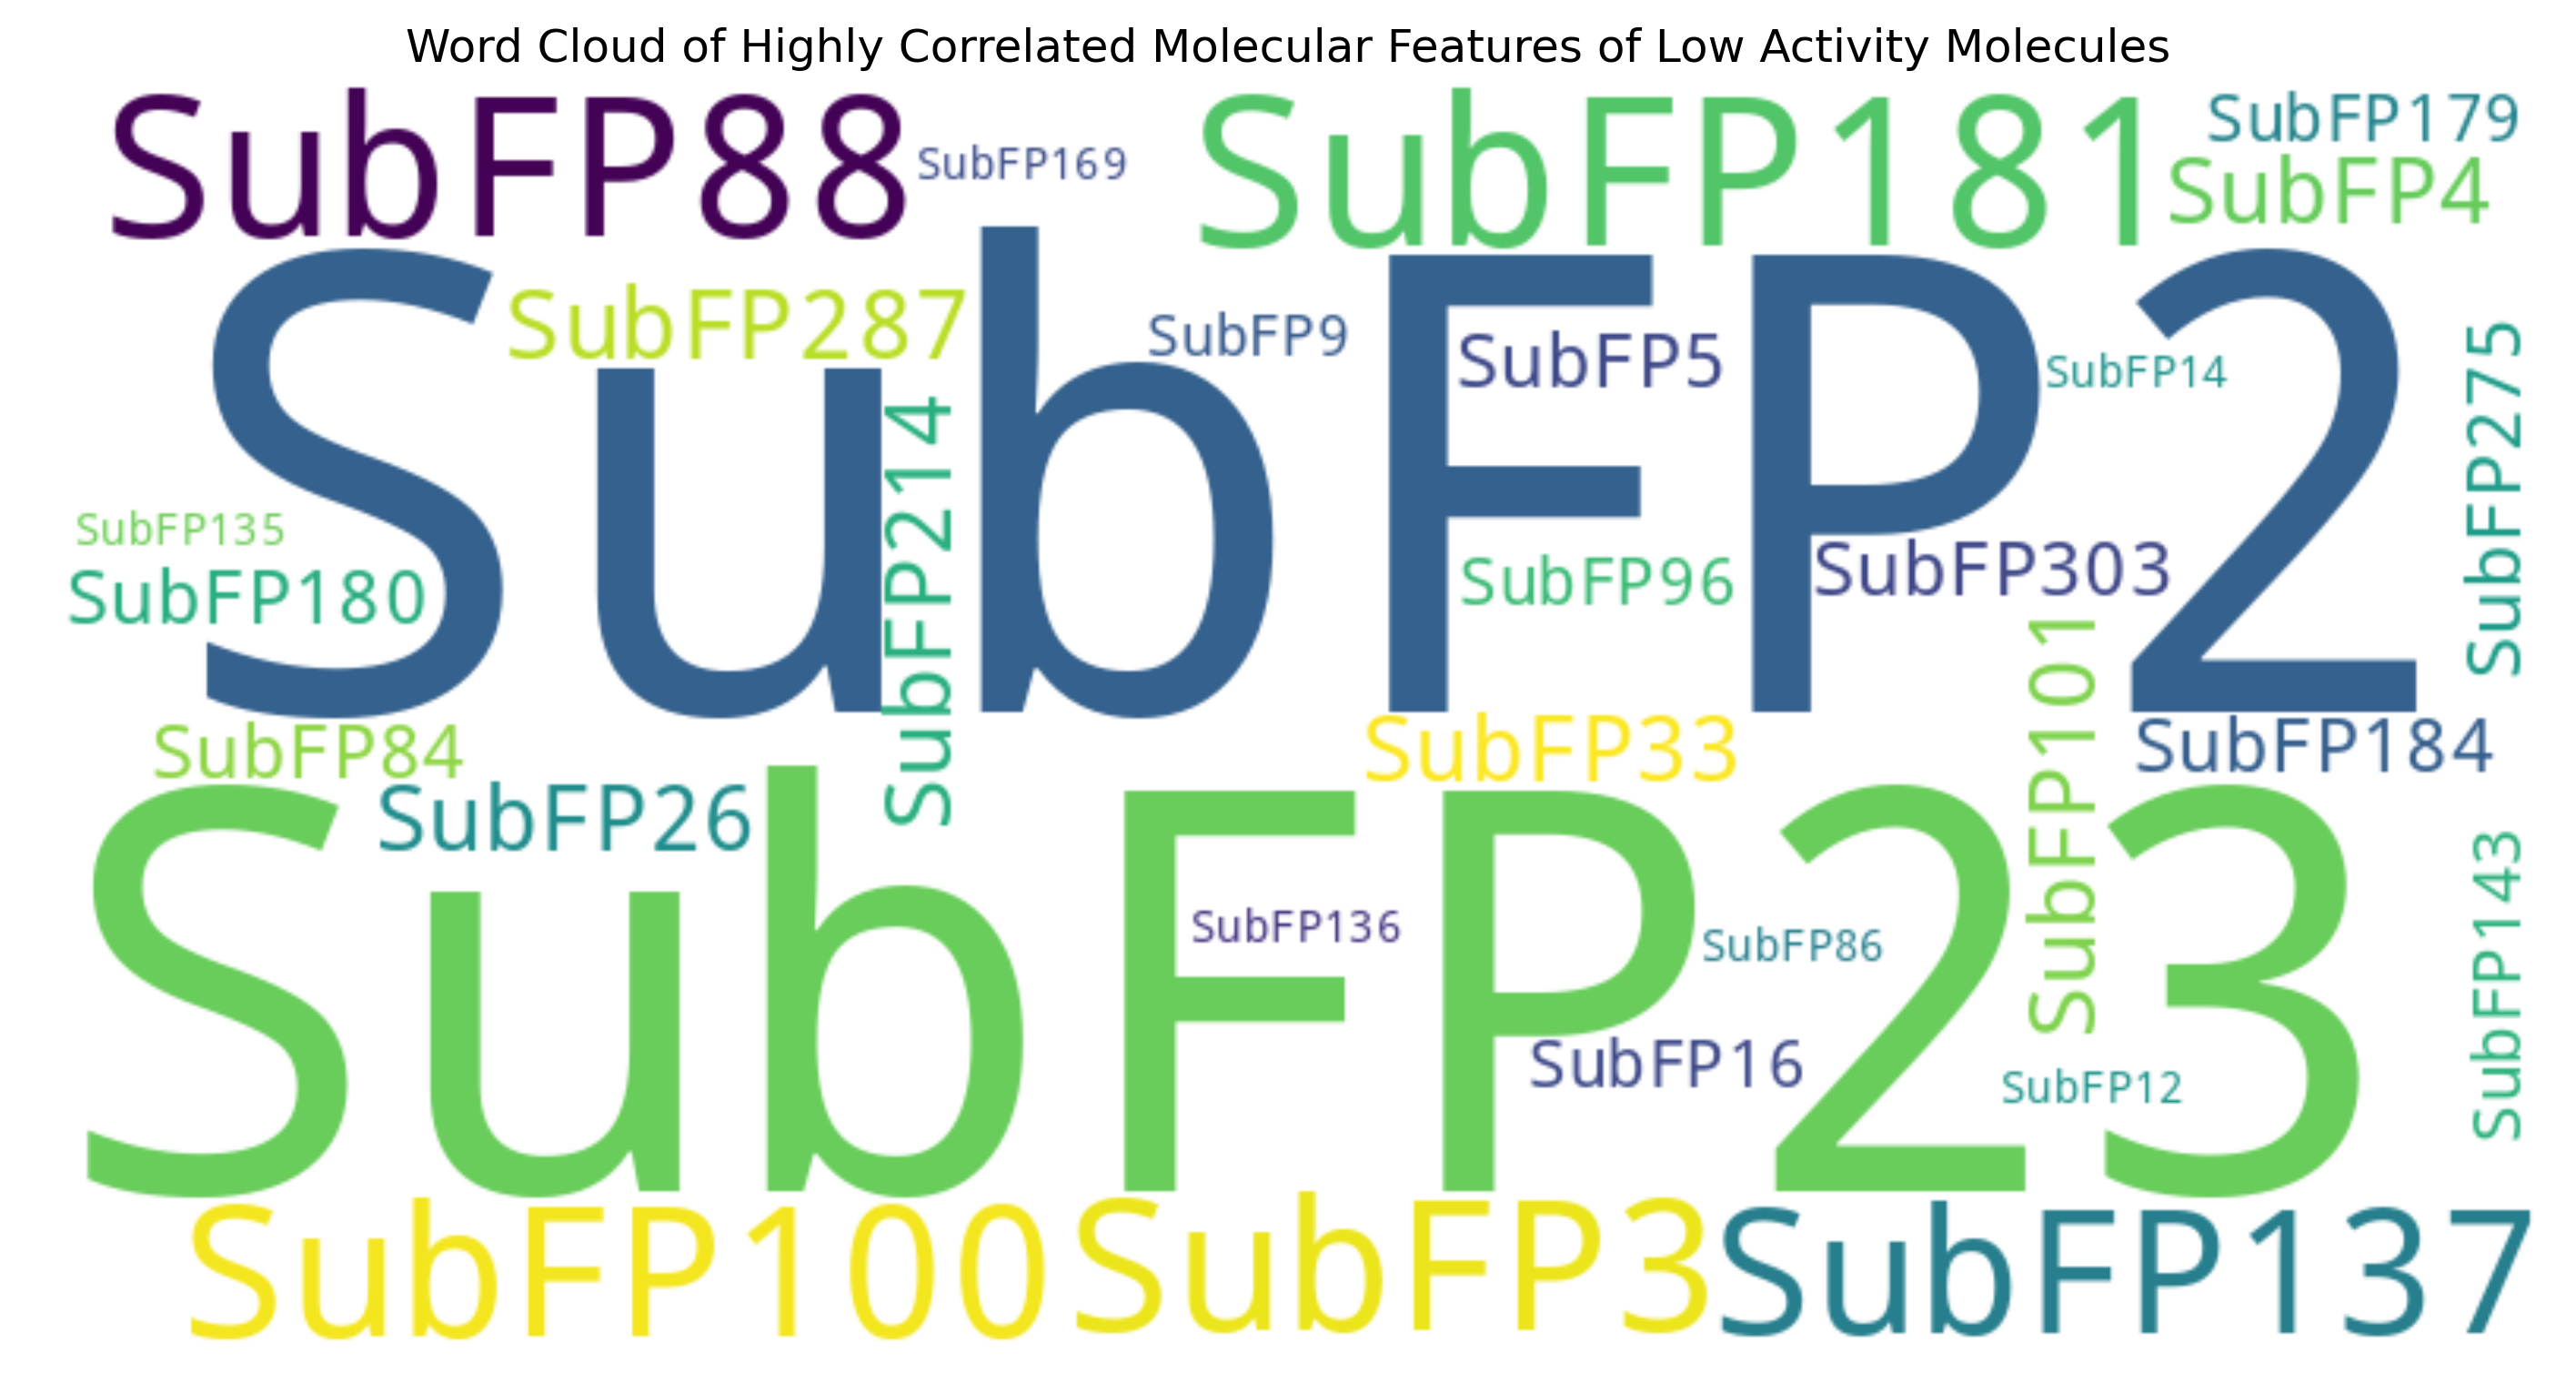

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Load the high-activity dataset
high_activity_file = "Low_Activity_Molecules.csv"
high_activity_df = pd.read_csv(high_activity_file)

# Drop unnecessary columns (pIC50, Dataset, Name)
feature_data = high_activity_df.drop(columns=["pIC50", "Dataset", "Name"])

# Compute Correlation Matrix
correlation_matrix = feature_data.corr()

# Extract highly correlated features (|correlation| > 0.75)
high_correlation = (correlation_matrix.abs() > 0.50) & (correlation_matrix != 1.0)
important_features = high_correlation.sum(axis=1)
important_features = important_features[important_features > 0]  # Keep only relevant features

# Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(important_features)

# Plot the Word Cloud
plt.figure(figsize=(12, 6), dpi=300)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Highly Correlated Molecular Features of Low Activity Molecules")

# Save the word cloud plot
wordcloud_plot_path = "WordCloud_Highly_Correlated_Features_Low_Activity_Molecules.png"
plt.savefig(wordcloud_plot_path, dpi=600)
plt.show()

# Display important features in a DataFrame
important_features_df = important_features.reset_index()
important_features_df.columns = ["Feature", "Correlation Count"]

In [ ]:
import pandas as pd

# Load the new dataset
new_molecules_file = "subs_desc.csv"
new_molecules_df = pd.read_csv(new_molecules_file)

# Extract molecule names
molecule_names = new_molecules_df["Name"]

# Subset only the descriptors used in the trained ANN model
selected_features = X_train.columns  # Get the feature names from the trained model
filtered_new_molecules = new_molecules_df[selected_features]  # Keep only relevant descriptors

# Predict pIC50 values using the trained ANN model
predicted_pic50 = best_ann.predict(filtered_new_molecules)

# Save predictions in a DataFrame
predictions_df = pd.DataFrame({
    "Name": molecule_names,
    "Predicted_pIC50": predicted_pic50
})

# Save predictions to CSV
predictions_file_path = "Predicted_pIC50_New_Molecules.csv"
predictions_df.to_csv(predictions_file_path, index=False)

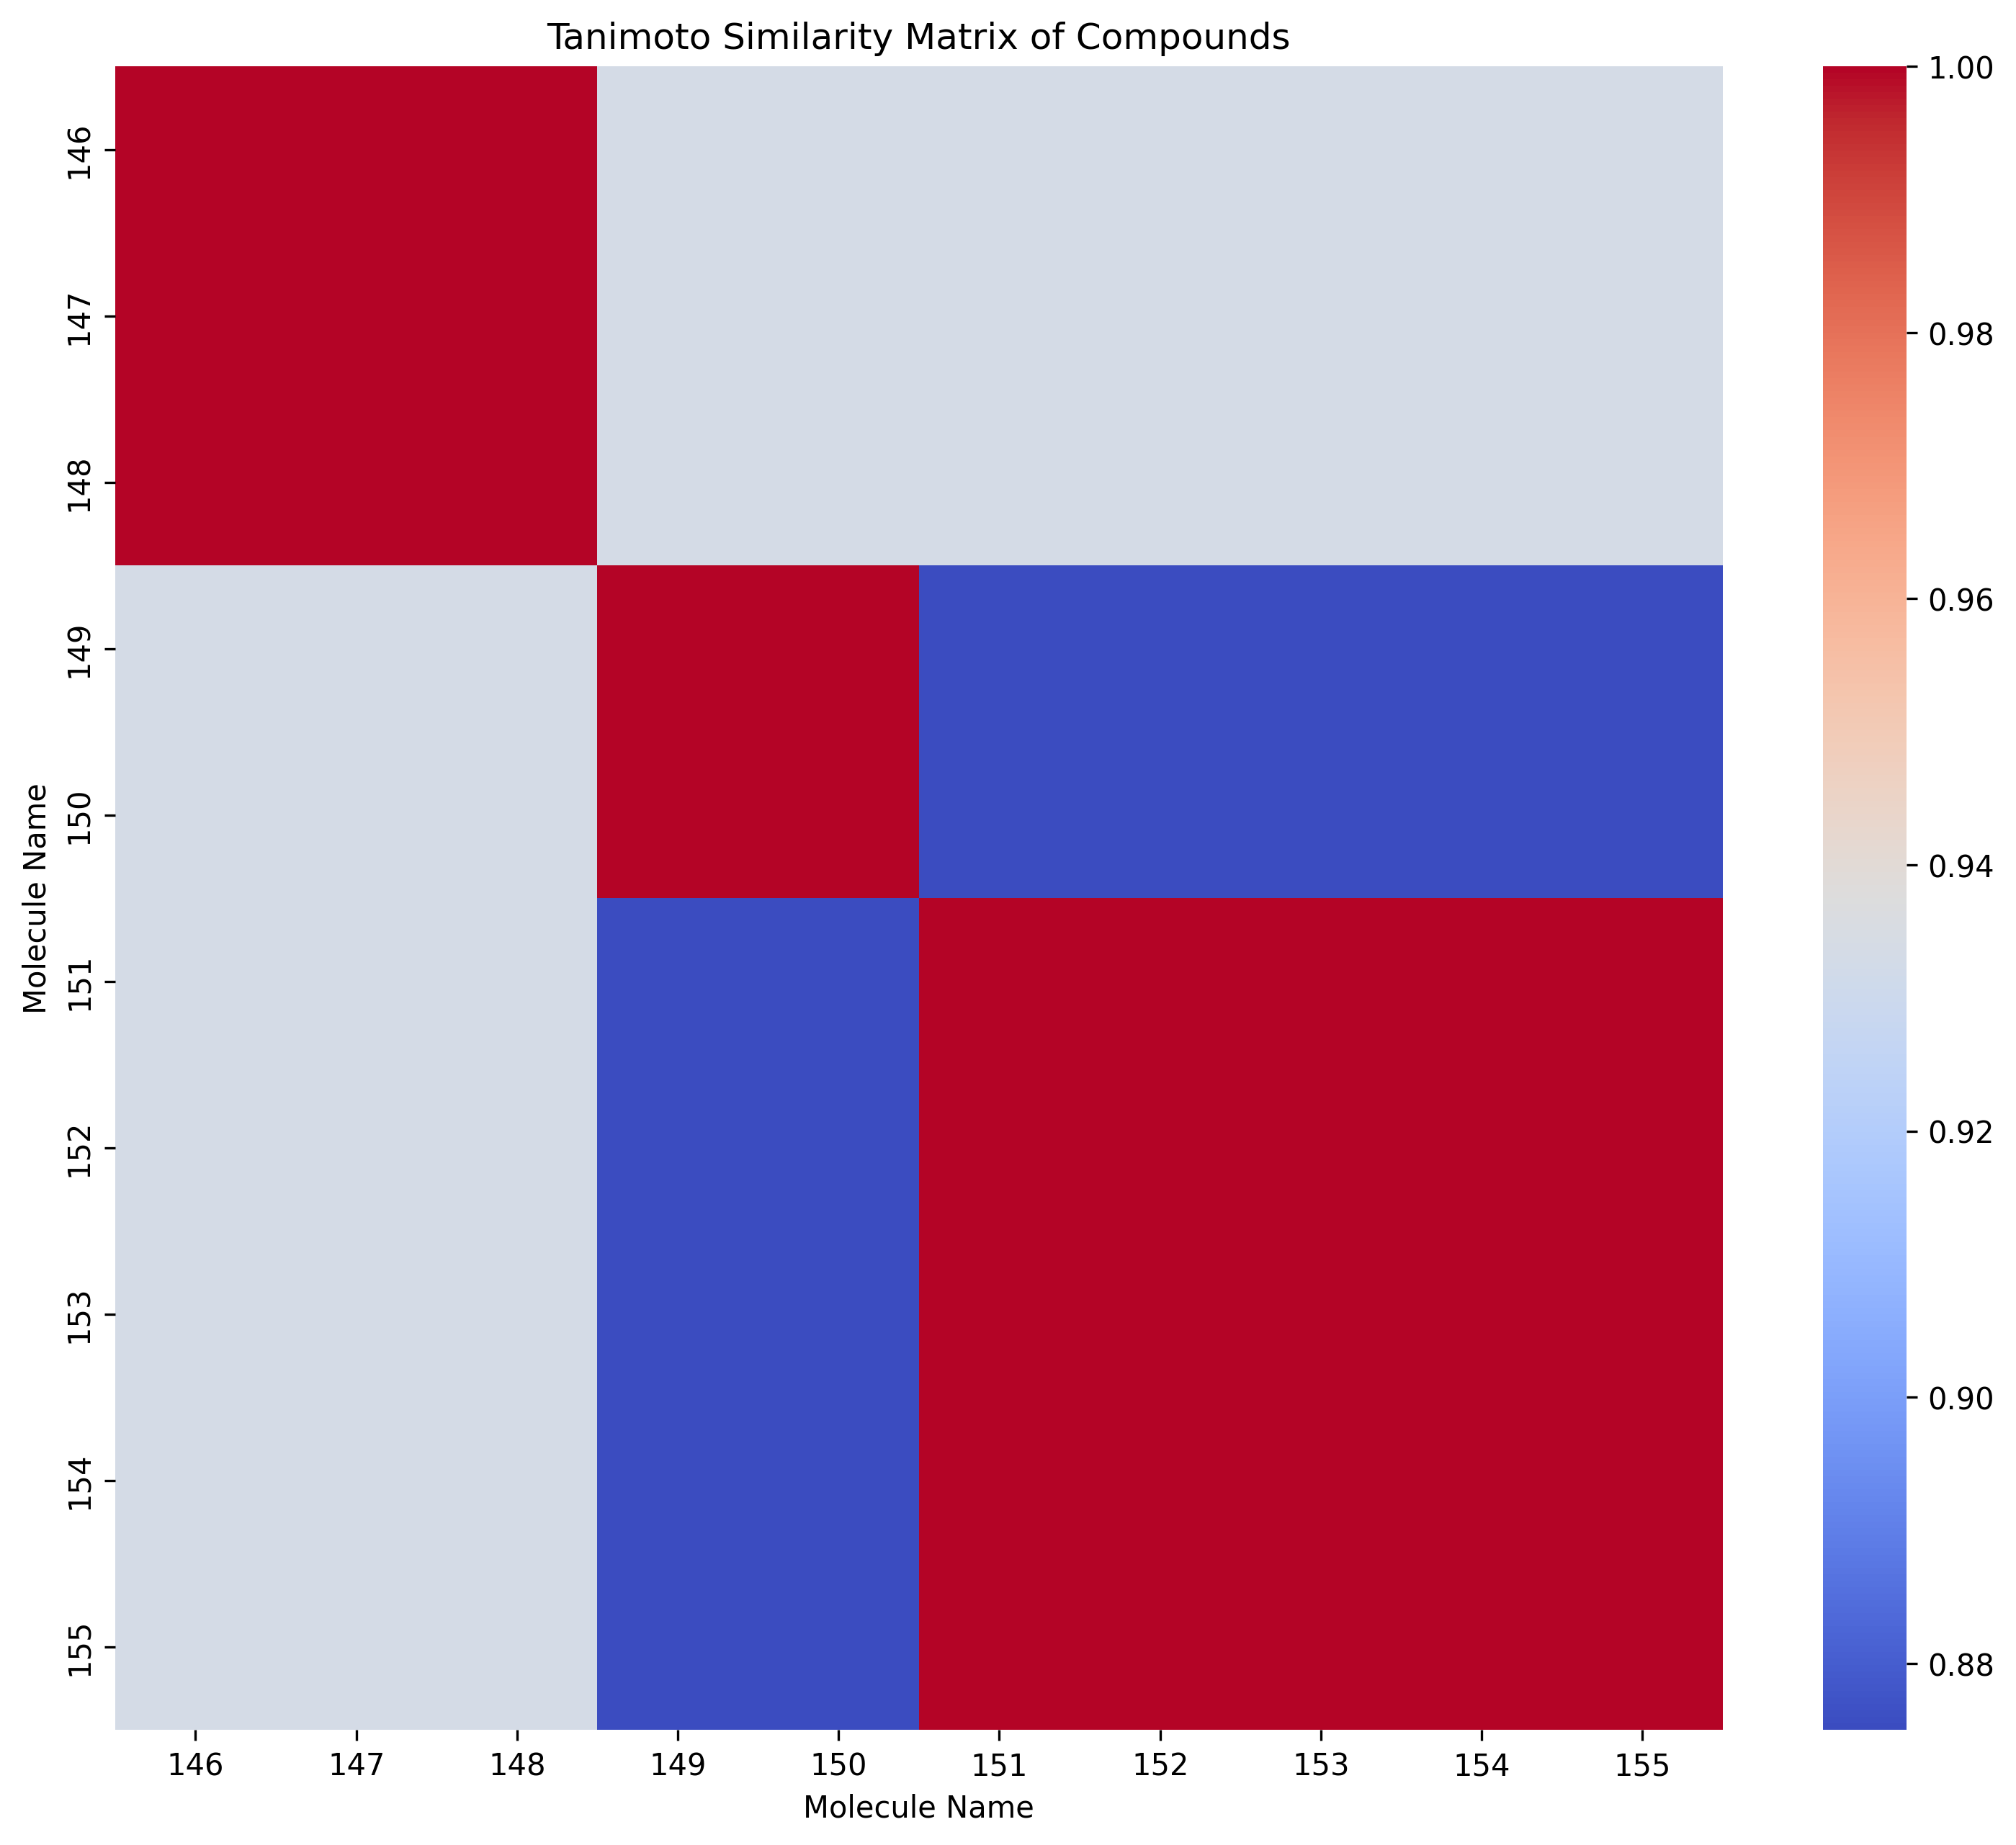

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform

# Load the dataset
file_path = "subs_desc.csv"
df = pd.read_csv(file_path)

# Extract molecule names
molecule_names = df["Name"]

# Drop the Name column to keep only descriptors
descriptor_data = df.drop(columns=["Name"])

# Compute Tanimoto similarity matrix using Jaccard distance
tanimoto_matrix = 1 - squareform(pdist(descriptor_data, metric="jaccard"))

# Convert to DataFrame for visualization
tanimoto_df = pd.DataFrame(tanimoto_matrix, index=molecule_names, columns=molecule_names)

# Plot the heatmap
plt.figure(figsize=(12, 10), dpi=300)
sns.heatmap(tanimoto_df, cmap="coolwarm", xticklabels=True, yticklabels=True)
plt.title("Tanimoto Similarity Matrix of Compounds")
plt.xlabel("Molecule Name")
plt.ylabel("Molecule Name")

# Save the heatmap at 600 DPI
tanimoto_plot_path = "Tanimoto_Similarity_Matrix.png"
plt.savefig(tanimoto_plot_path, dpi=600)
plt.show()

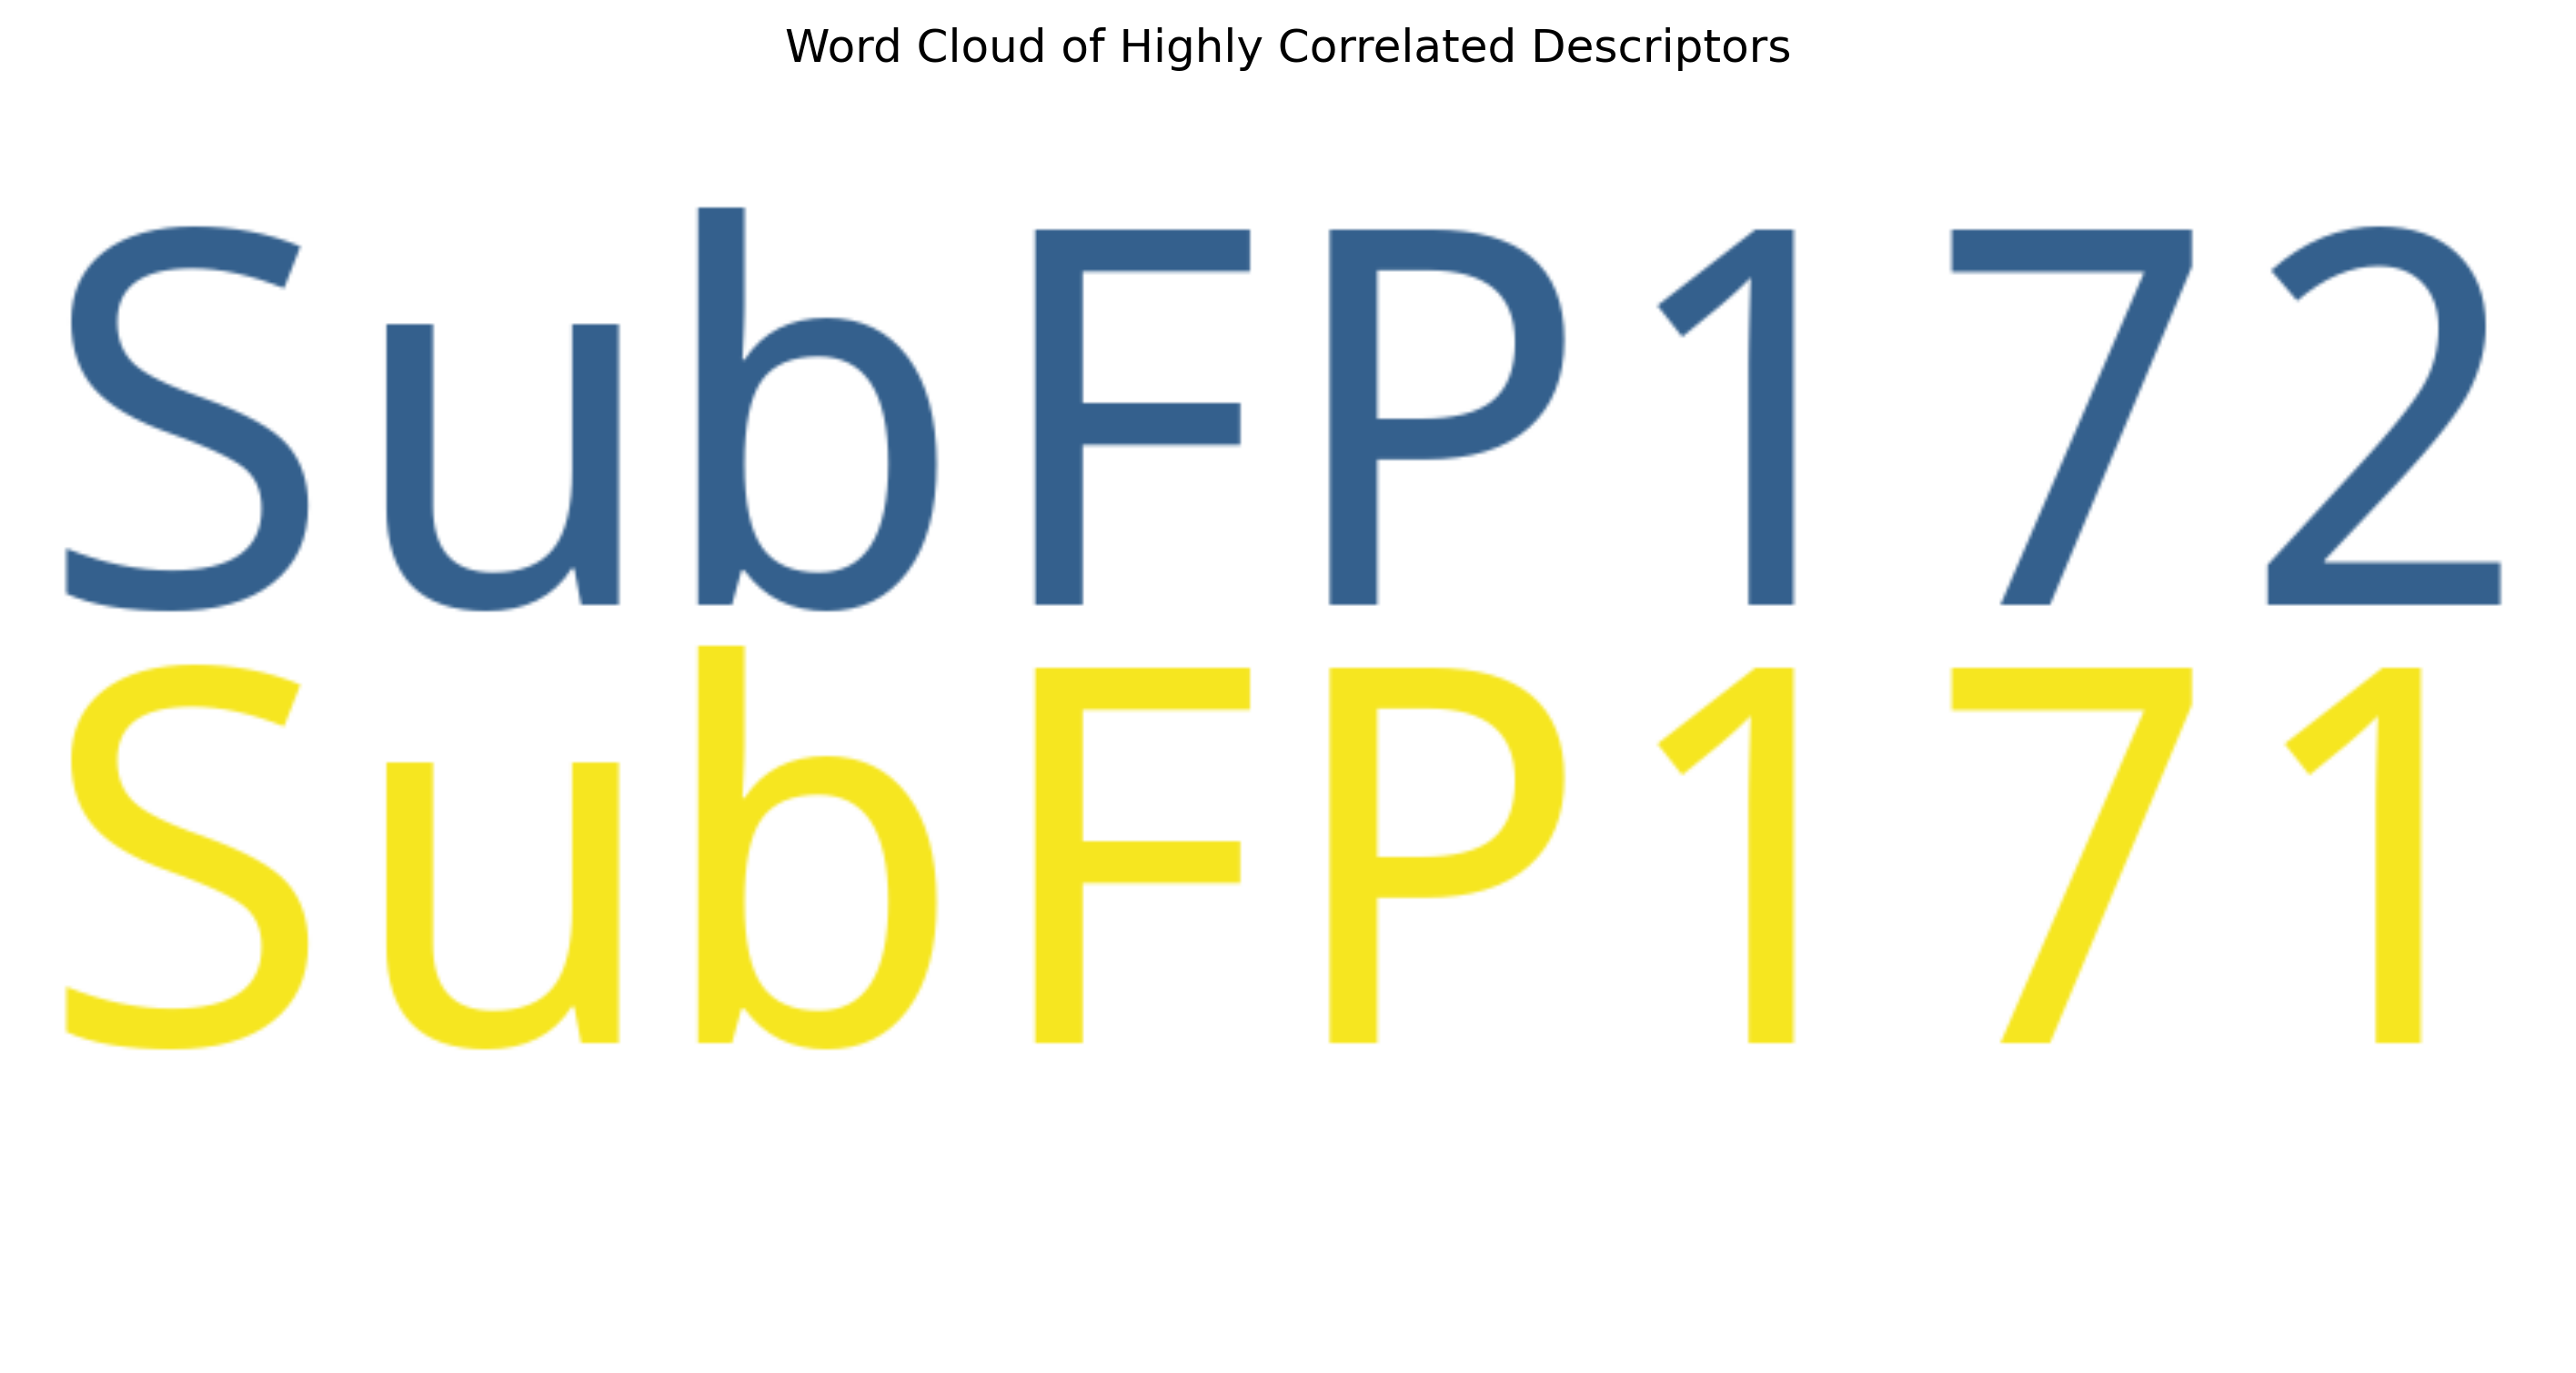

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Load the dataset
file_path = "subs_desc.csv"
df = pd.read_csv(file_path)

# Drop the Name column to keep only descriptors
descriptor_data = df.drop(columns=["Name"])

# Compute Pearson correlation matrix
correlation_matrix = descriptor_data.corr()

# Identify descriptors with correlation > 0.50 (highly correlated)
highly_correlated = (correlation_matrix.abs() > 0.40) & (correlation_matrix != 1.0)

# Count the number of high correlations for each descriptor
descriptor_correlation_scores = highly_correlated.sum(axis=1)

# Convert to dictionary for word cloud generation
descriptor_dict = descriptor_correlation_scores.to_dict()

# Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(descriptor_dict)

# Plot the Word Cloud
plt.figure(figsize=(12, 6), dpi=300)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Highly Correlated Descriptors")

# Save the word cloud plot at 600 DPI
wordcloud_plot_path = "WordCloud_Highly_Correlated_Pearson_new_molecules.png"
plt.savefig(wordcloud_plot_path, dpi=600)
plt.show()

In [ ]:
!zip -r substructure_fp_model.zip /content

updating: content/ (stored 0%)
updating: content/.config/ (stored 0%)
updating: content/.config/.last_update_check.json (deflated 23%)
updating: content/.config/gce (stored 0%)
updating: content/.config/.last_opt_in_prompt.yaml (stored 0%)
updating: content/.config/active_config (stored 0%)
updating: content/.config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db (deflated 97%)
updating: content/.config/.last_survey_prompt.yaml (stored 0%)
updating: content/.config/default_configs.db (deflated 98%)
updating: content/.config/logs/ (stored 0%)
updating: content/.config/logs/2025.02.04/ (stored 0%)
updating: content/.config/logs/2025.02.04/14.21.52.139422.log (deflated 58%)
updating: content/.config/logs/2025.02.04/14.22.00.295415.log (deflated 87%)
updating: content/.config/logs/2025.02.04/14.22.01.262398.log (deflated 58%)
updating: content/.config/logs/2025.02.04/14.22.09.907842.log (deflated 57%)
updating: content/.config/logs/2025.02.04/14.22.10.555414.log (deflated 56